In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, Normalizer
from sklearn.feature_selection import SelectKBest

In [ ]:
df = pd.read_csv("Loan Prediction/Training Data.csv")
df.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


In [ ]:
columns_list = [x.lower() for x in list(df.columns)]
df.columns = columns_list

In [ ]:
df.columns

Index(['id', 'income', 'age', 'experience', 'married/single',
       'house_ownership', 'car_ownership', 'profession', 'city', 'state',
       'current_job_yrs', 'current_house_yrs', 'risk_flag'],
      dtype='object')

In [ ]:
df.shape

(252000, 13)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   id                 252000 non-null  int64 
 1   income             252000 non-null  int64 
 2   age                252000 non-null  int64 
 3   experience         252000 non-null  int64 
 4   married/single     252000 non-null  object
 5   house_ownership    252000 non-null  object
 6   car_ownership      252000 non-null  object
 7   profession         252000 non-null  object
 8   city               252000 non-null  object
 9   state              252000 non-null  object
 10  current_job_yrs    252000 non-null  int64 
 11  current_house_yrs  252000 non-null  int64 
 12  risk_flag          252000 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 25.0+ MB


In [ ]:
# rename the column married/single into marital_status
df.rename({'married/single':'marital_status'},axis=1, inplace=True)
df.columns

Index(['id', 'income', 'age', 'experience', 'marital_status',
       'house_ownership', 'car_ownership', 'profession', 'city', 'state',
       'current_job_yrs', 'current_house_yrs', 'risk_flag'],
      dtype='object')

In [ ]:
# Numerical Values
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,252000.0,1.260005e+05,7.274628e+04,1.0,63000.75,126000.5,189000.25,252000.0
income,252000.0,4.997117e+06,2.878311e+06,10310.0,2503015.00,5000694.5,7477502.00,9999938.0
age,252000.0,4.995407e+01,1.706385e+01,21.0,35.00,50.0,65.00,79.0
experience,252000.0,1.008444e+01,6.002590e+00,0.0,5.00,10.0,15.00,20.0
current_job_yrs,252000.0,6.333877e+00,3.647053e+00,0.0,3.00,6.0,9.00,14.0
current_house_yrs,252000.0,1.199779e+01,1.399037e+00,10.0,11.00,12.0,13.00,14.0
risk_flag,252000.0,1.230000e-01,3.284379e-01,0.0,0.00,0.0,0.00,1.0


In [ ]:
# Categorical Values
df.describe(include=['O']).T

,count,unique,top,freq
marital_status,252000,2,single,226272
house_ownership,252000,3,rented,231898
car_ownership,252000,2,no,176000
profession,252000,51,Physician,5957
city,252000,317,Vijayanagaram,1259
state,252000,29,Uttar_Pradesh,28400


In [ ]:
df.duplicated().sum()

0

In [ ]:
df.drop("id", axis=1, inplace=True)
df.columns

Index(['income', 'age', 'experience', 'marital_status', 'house_ownership',
       'car_ownership', 'profession', 'city', 'state', 'current_job_yrs',
       'current_house_yrs', 'risk_flag'],
      dtype='object')

In [ ]:
df.isna().sum()

income               0
age                  0
experience           0
marital_status       0
house_ownership      0
car_ownership        0
profession           0
city                 0
state                0
current_job_yrs      0
current_house_yrs    0
risk_flag            0
dtype: int64

In [ ]:
# lets look into  state feature values
df.state.unique()

array(['Madhya_Pradesh', 'Maharashtra', 'Kerala', 'Odisha', 'Tamil_Nadu',
       'Gujarat', 'Rajasthan', 'Telangana', 'Bihar', 'Andhra_Pradesh',
       'West_Bengal', 'Haryana', 'Puducherry', 'Karnataka',
       'Uttar_Pradesh', 'Himachal_Pradesh', 'Punjab', 'Tripura',
       'Uttarakhand', 'Jharkhand', 'Mizoram', 'Assam',
       'Jammu_and_Kashmir', 'Delhi', 'Chhattisgarh', 'Chandigarh',
       'Uttar_Pradesh[5]', 'Manipur', 'Sikkim'], dtype=object)

In [ ]:
# removing extra symbols and convert words into lowercase
df['state'] = df['state'].apply(lambda x: re.sub('[^a-zA-Z]+', ' ',x))
df['state'] = df['state'].apply(lambda x: x.lower())

In [ ]:
df.state.unique()

array(['madhya pradesh', 'maharashtra', 'kerala', 'odisha', 'tamil nadu',
       'gujarat', 'rajasthan', 'telangana', 'bihar', 'andhra pradesh',
       'west bengal', 'haryana', 'puducherry', 'karnataka',
       'uttar pradesh', 'himachal pradesh', 'punjab', 'tripura',
       'uttarakhand', 'jharkhand', 'mizoram', 'assam',
       'jammu and kashmir', 'delhi', 'chhattisgarh', 'chandigarh',
       'uttar pradesh ', 'manipur', 'sikkim'], dtype=object)

In [ ]:
# if we observ the value uttar pradesh occured twice , containing the extra spaces which causing the extra unique value
# lets fix this
df['state'] = df['state'].str.strip()
df.state.unique()

array(['madhya pradesh', 'maharashtra', 'kerala', 'odisha', 'tamil nadu',
       'gujarat', 'rajasthan', 'telangana', 'bihar', 'andhra pradesh',
       'west bengal', 'haryana', 'puducherry', 'karnataka',
       'uttar pradesh', 'himachal pradesh', 'punjab', 'tripura',
       'uttarakhand', 'jharkhand', 'mizoram', 'assam',
       'jammu and kashmir', 'delhi', 'chhattisgarh', 'chandigarh',
       'manipur', 'sikkim'], dtype=object)

In [ ]:
# now lets look at the city feature column
df.city.unique()[:30]

array(['Rewa', 'Parbhani', 'Alappuzha', 'Bhubaneswar',
       'Tiruchirappalli[10]', 'Jalgaon', 'Tiruppur', 'Jamnagar',
       'Kota[6]', 'Karimnagar', 'Hajipur[31]', 'Adoni', 'Erode[17]',
       'Kollam', 'Madurai', 'Anantapuram[24]', 'Kamarhati', 'Bhusawal',
       'Sirsa', 'Amaravati', 'Secunderabad', 'Ahmedabad', 'Ajmer',
       'Ongole', 'Miryalaguda', 'Ambattur', 'Indore', 'Pondicherry',
       'Shimoga', 'Chennai'], dtype=object)

In [ ]:
# removing extra symbols and convert words into lowercase
df['city'] = df['city'].apply(lambda x: re.sub('[^a-zA-Z]+', ' ',x))
df['city'] = df['city'].apply(lambda x: x.lower())

In [ ]:
df.city.unique()[:30]

array(['rewa', 'parbhani', 'alappuzha', 'bhubaneswar', 'tiruchirappalli ',
       'jalgaon', 'tiruppur', 'jamnagar', 'kota ', 'karimnagar',
       'hajipur ', 'adoni', 'erode ', 'kollam', 'madurai', 'anantapuram ',
       'kamarhati', 'bhusawal', 'sirsa', 'amaravati', 'secunderabad',
       'ahmedabad', 'ajmer', 'ongole', 'miryalaguda', 'ambattur',
       'indore', 'pondicherry', 'shimoga', 'chennai'], dtype=object)

In [ ]:
# lets look into House Ownership feature values
df.house_ownership.value_counts()

rented          231898
owned            12918
norent_noown      7184
Name: house_ownership, dtype: int64

norent_noown case may be because of customer living with their parents and house owned by the parents themself.

In [ ]:
def data_stats(df, query_col, target_col, aggregation_func=np.mean, columns_list=None):
    """
    functions describe the basic stats (count, probability) groupby operations based on query column on target column

    """
    print(f'Total defaulters based on {query_col} \n')
    print(pd.crosstab(df[query_col], df[target_col], margins='True'))
    print("="*50)
    print(f'Proportion of defaulters based on {query_col} \n')
    print(pd.pivot_table(data=df, index=query_col, values=target_col, aggfunc=aggregation_func, columns=columns_list,sort=True))


In [ ]:
## inspired from AAIC
def plot_bargraph(data,  xtick, target_col, measure_col='total_records'):
    """
    functions plot the bar graph based on filtered dataframe
    """
    index = np.arange(data.shape[0])
    plt.figure(figsize=(16,8))
    p1 = plt.bar(index, data[measure_col].values, color='g')
    p2 = plt.bar(index, data[target_col].values, color='r')

    plt.xlabel(xtick)
    plt.ylabel('Records')
    plt.title(f'{xtick.upper()} wise Loan At Risk')
    plt.xticks(index, list(data[xtick].values),rotation=90)
    plt.legend((p1[0], p2[0]),('total','@risk'))

    plt.show()

In [ ]:
## inspired from AAIC
def univariate_barplot(data, query_col, targate_col, top=False):
    """
    functions perform groupby operation on query column to find the basic stats like count of occurences
    based on query column on target column
    """
    temp = data.groupby([query_col])[targate_col].agg(lambda x:x.eq(1).sum()).reset_index()
    temp['total_records'] = data.groupby([query_col])[targate_col].agg(total='count').reset_index()['total']
    temp['Average_@risk'] = data.groupby([query_col])[targate_col].agg(Avg='mean').reset_index()['Avg']

    temp.sort_values(by=['total_records'],inplace=True, ascending=False)


    if top:
        temp = temp[0:top]
    plot_bargraph(temp, xtick=query_col, target_col=targate_col)
    temp.sort_values(by='Average_@risk',inplace=True)
    print(f'Top 5 with Least Default Rate: {query_col.upper()}')
    print(temp.head(5))
    print("="*50)
    print(f'Top 5 with Most Default Rate: {query_col.upper()}')
    print(temp.tail(5))

# Exploratory Data Analysis

## Class Distribution

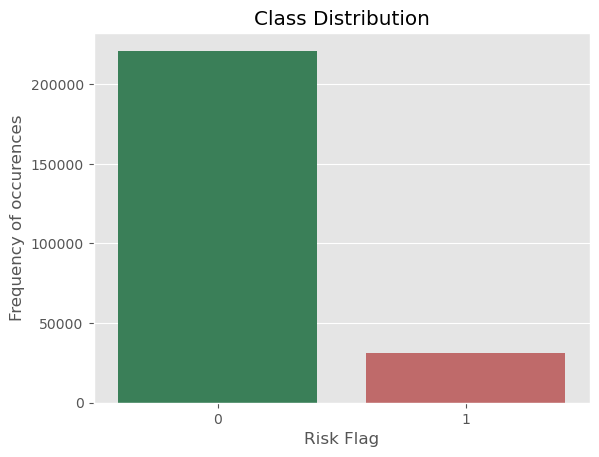

Percentage of data belonging to Class 0 : 87.7 %
Percentage of data belonging to Class 1 : 12.3 %


In [ ]:
palette_colors = {0: '#2E8B57', 1: '#CD5C5C'}
sns.countplot(x='risk_flag',data=df,palette=palette_colors)
plt.xlabel('Risk Flag')
plt.ylabel('Frequency of occurences')
plt.title('Class Distribution')
plt.show()

print('Percentage of data belonging to Class 0 :', (df['risk_flag'].value_counts()[0]/df.shape[0])*100,'%')
print('Percentage of data belonging to Class 1 :', (df['risk_flag'].value_counts()[1]/df.shape[0])*100,'%')

**Observation**

Clear imbalance in the class distribution with approximately 88% of the records belonging to class 0 and around 13% associated with class 1.

## Marital Status

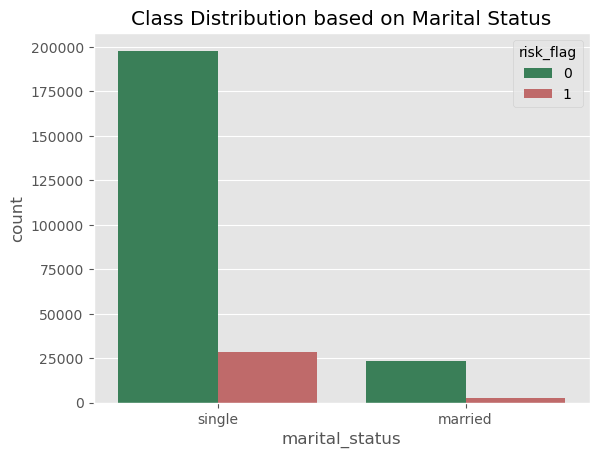

In [ ]:
palette_colors = {0: '#2E8B57', 1: '#CD5C5C'}
sns.countplot(x='marital_status', data=df, hue='risk_flag', palette=palette_colors)
plt.title('Class Distribution based on Marital Status')
plt.show()

In [ ]:
data_stats(df, query_col='marital_status', target_col='risk_flag')

Total defaulters based on marital_status 

risk_flag            0      1     All
marital_status                       
married          23092   2636   25728
single          197912  28360  226272
All             221004  30996  252000
Proportion of defaulters based on marital_status 

                risk_flag
marital_status           
married          0.102456
single           0.125336


**Observation**

- Major chuck of a customer approx **90%** data belongs to unmarried(single) category which is unusual as married people take the loan more often for building home and other but they consist of only **10%** of overall data.
- Interesting to see that still the loan default rate for married is **10% and unmarried (single) is 12%.**
- Unless the data belongs to unmarried customer but still we see approx only **2% difference in default rate.**

## Car Ownership

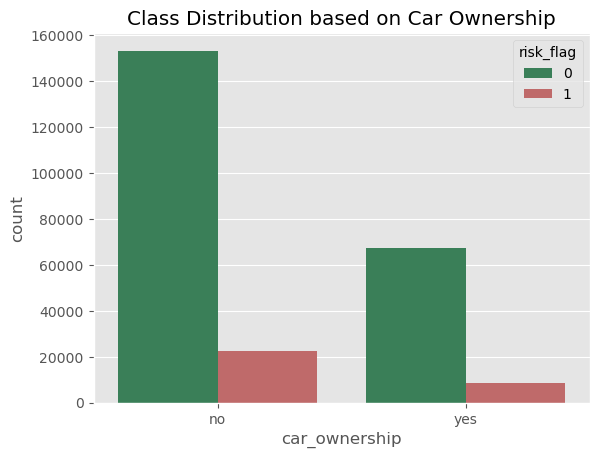

In [ ]:
palette_colors = {0: '#2E8B57', 1: '#CD5C5C'}
sns.countplot(x='car_ownership', data=df, hue='risk_flag', palette=palette_colors)
plt.title('Class Distribution based on Car Ownership')
plt.show()


In [ ]:
data_stats(df,'car_ownership', 'risk_flag',)

Total defaulters based on car_ownership 

risk_flag           0      1     All
car_ownership                       
no             153439  22561  176000
yes             67565   8435   76000
All            221004  30996  252000
Proportion of defaulters based on car_ownership 

               risk_flag
car_ownership           
no              0.128188
yes             0.110987


**Observation**
- Only **30%** customer owns the car where as **70%** don't have any car.
- Considering the record number we see the defualt rate which is 12.8% for not having car and 11% having car-ownership.
- But having An asset increase customer credit and we still see small but valid difference in defualt rate of 2% approx

## House Ownership

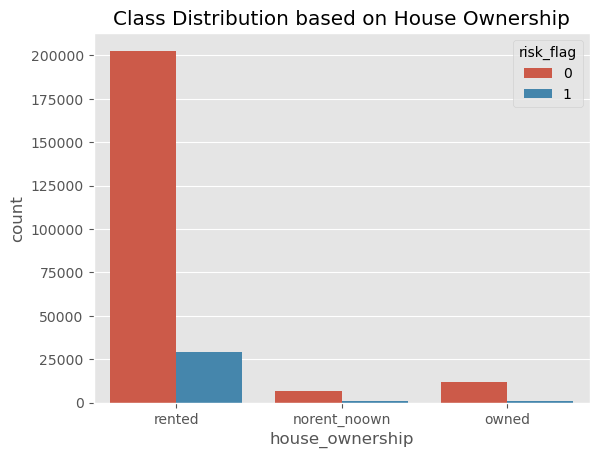

In [ ]:
sns.countplot(x='house_ownership', data=df, hue='risk_flag')
plt.title('Class Distribution based on House Ownership')
plt.show()

In [ ]:
data_stats(df,'house_ownership', 'risk_flag')

Total defaulters based on house_ownership 

risk_flag             0      1     All
house_ownership                       
norent_noown       6469    715    7184
owned             11758   1160   12918
rented           202777  29121  231898
All              221004  30996  252000
Proportion of defaulters based on house_ownership 

                 risk_flag
house_ownership           
norent_noown      0.099527
owned             0.089797
rented            0.125577


**Observations**
- Measuring the category distribution 2% belongs to not rented/not own, approx. 5% belongs to owned and more than 92% belongs to rented customers.
- Major chunk of customer's living in rented house/flat with default rate of 12% which is quite higher than the other two categories owned only 8% and not rented/ not owned which is 9%.
- Customer living on rent basis tend to apply for loan's more often 231898 out off 252000 for buidling their own houses or buying new flat in urban areas, which gives these kind of higher records count.
- The category norent/noown these may be, are the customers who were living with their parents or living in joint family and house owned by the elder person in the house.

## Customer Age

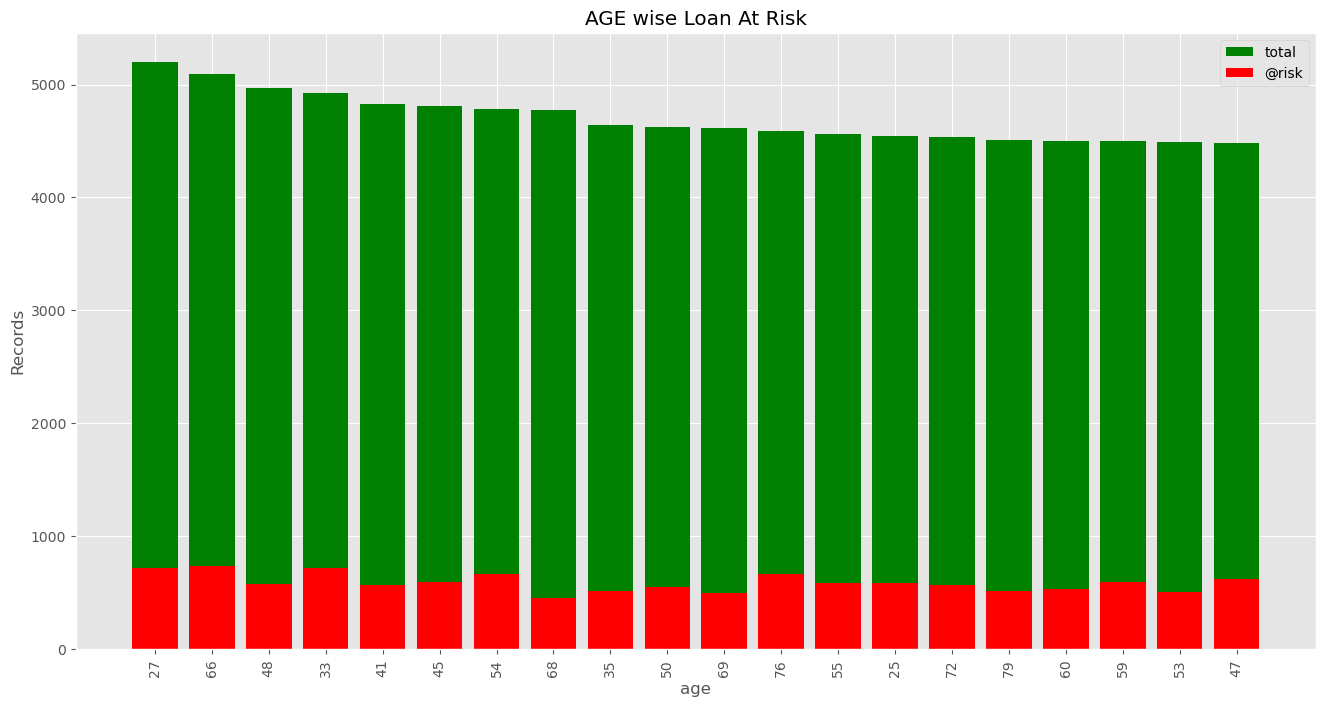

Top 5 with Least Default Rate: AGE
    age  risk_flag  total_records  Average_@risk
47   68        451           4772       0.094510
48   69        497           4617       0.107646
14   35        513           4643       0.110489
32   53        501           4490       0.111581
58   79        513           4505       0.113873
Top 5 with Most Default Rate: AGE
    age  risk_flag  total_records  Average_@risk
33   54        660           4785       0.137931
6    27        720           5197       0.138541
45   66        737           5092       0.144737
55   76        666           4585       0.145256
12   33        719           4921       0.146109


In [ ]:
univariate_barplot(df, 'age', 'risk_flag', top=20)

**Observations**
- Looking at the Bar Chart we have Age Range of 25 to 79
- Customer with Age 27 has highest number of total record count more than 5500+ followed by 66 with 5200 records and 48 with 4900+ records
- We observ approx. similar distribution of total record count for all Age number but un-even risk flag count and defualt rate
- The Age 33 has most higher defualt rate of 14.61% and least 9.4% for Age 68 which is quite amazing as customer with older age has lower rate of default, normally we consider the older age customer @risk of loan default.

# Age Type

In [ ]:
def age_type(age):
    if age > 19 and  age <= 29:
        return 'Young'
    elif age > 29 and age <= 39:
        return 'Adults'
    elif age > 39 and age <= 60:
        return 'Middle'
    else:
        return 'old'

- lets group the age based on 19-29 as young, 30 to 39 as adults, 40 to 60 as middle and 61-80 as old

In [ ]:
df['age_type'] = df.age.map(age_type)
df.age_type.value_counts()

Middle    90272
old       80812
Adults    41727
Young     39189
Name: age_type, dtype: int64

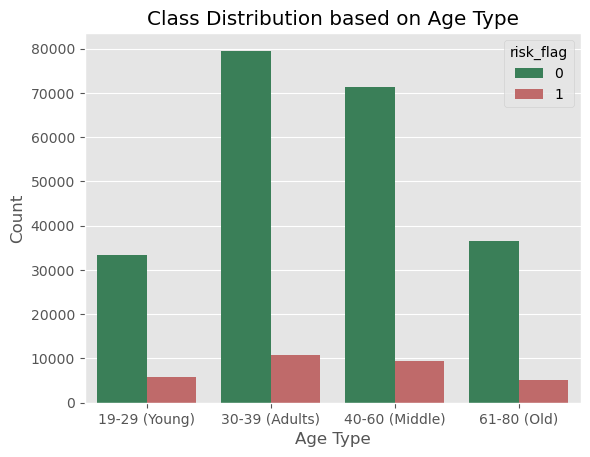

In [ ]:
# Define the neutral color palette
palette_colors = {0: '#2E8B57', 1: '#CD5C5C'}

# Plot the countplot with labeled age types
ax = sns.countplot(x='age_type', data=df, hue='risk_flag', palette=palette_colors)
plt.title('Class Distribution based on Age Type')
plt.xlabel('Age Type')
plt.ylabel('Count')

# Specify the tick locations and labels
xtick_locations = [0, 1, 2, 3]
xtick_labels = ['19-29 (Young)', '30-39 (Adults)', '40-60 (Middle)', '61-80 (Old)']

# Set the tick locations and labels
ax.set_xticks(xtick_locations)
ax.set_xticklabels(xtick_labels)

plt.show()


In [ ]:
data_stats(df,'age_type', 'risk_flag')

Total defaulters based on age_type 

risk_flag       0      1     All
age_type                        
Adults      36636   5091   41727
Middle      79540  10732   90272
Young       33460   5729   39189
old         71368   9444   80812
All        221004  30996  252000
Proportion of defaulters based on age_type 

          risk_flag
age_type           
Adults     0.122007
Middle     0.118885
Young      0.146189
old        0.116864


**Observations**
- Over 90K customer Aged group as Middle Age customer, 80K as old , 41K as Adults and 39K as Young customers
- Comparing the default rate we see that Younger customer has higher rate of default i.e. 14.6% and older customer with least default rate of 11.6% as we seen before.
- Young people take the loans for their educations, startup bussiness etc, which not always helps them hence we see higher default rate.

## State

### Income

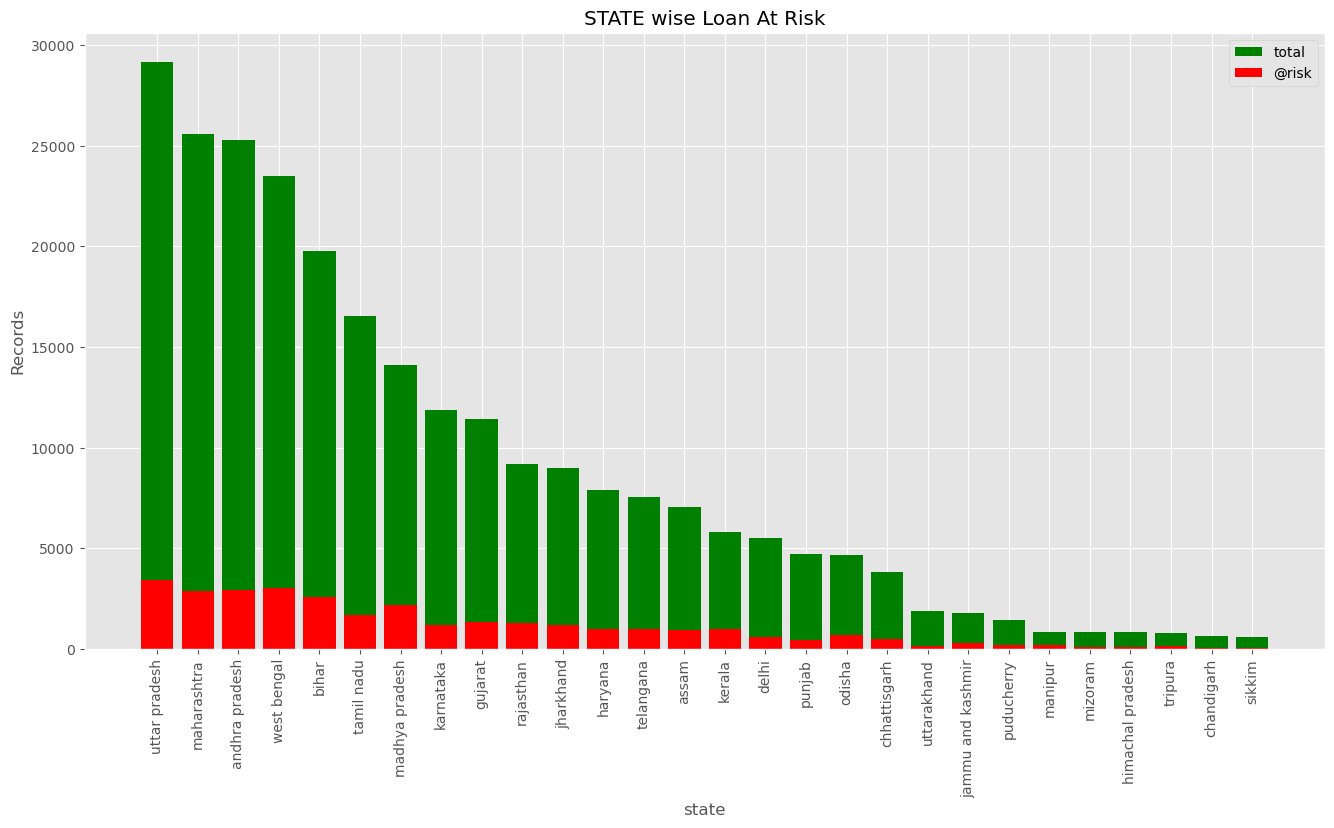

Top 5 with Least Default Rate: STATE
          state  risk_flag  total_records  Average_@risk
21       sikkim         28            608       0.046053
26  uttarakhand        133           1874       0.070971
19       punjab        425           4720       0.090042
3    chandigarh         61            656       0.092988
11    karnataka       1189          11855       0.100295
Top 5 with Most Default Rate: STATE
                state  risk_flag  total_records  Average_@risk
13     madhya pradesh       2180          14122       0.154369
9   jammu and kashmir        283           1780       0.158989
12             kerala        970           5805       0.167097
24            tripura        136            809       0.168109
15            manipur        183            849       0.215548


In [ ]:
univariate_barplot(df, 'state', 'risk_flag' )

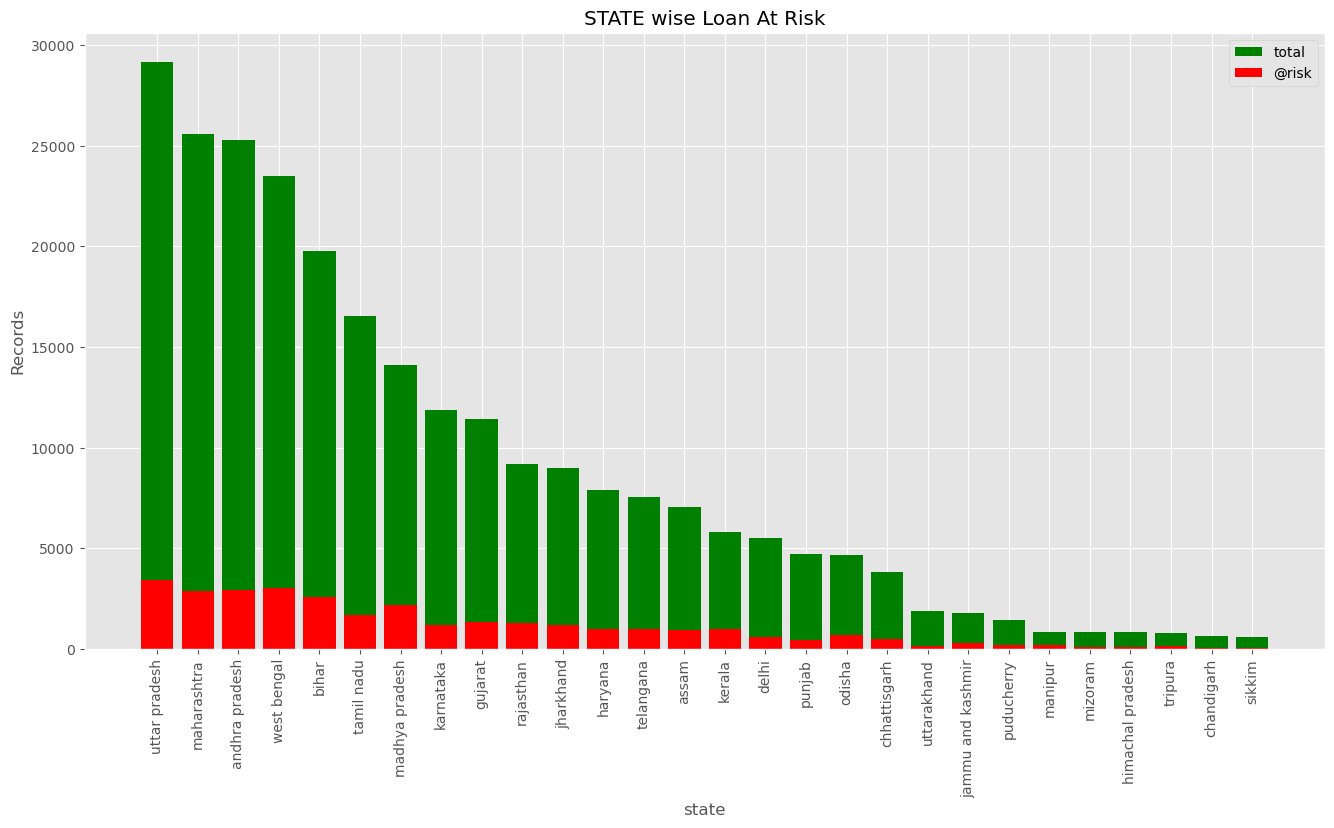

Top 5 with Least Default Rate: STATE
          state  risk_flag  total_records  Average_@risk
21       sikkim         28            608       0.046053
26  uttarakhand        133           1874       0.070971
19       punjab        425           4720       0.090042
3    chandigarh         61            656       0.092988
11    karnataka       1189          11855       0.100295
Top 5 with Most Default Rate: STATE
                state  risk_flag  total_records  Average_@risk
13     madhya pradesh       2180          14122       0.154369
9   jammu and kashmir        283           1780       0.158989
12             kerala        970           5805       0.167097
24            tripura        136            809       0.168109
15            manipur        183            849       0.215548


In [ ]:
univariate_barplot(df, 'state', 'risk_flag' )

**Observations**
- Top 5 state with highest total records Utter-Pradesh > Maharastra > Aadhra-Pradesh > West Bangal > Bihar the major of records data are coming from these five states only approx. 48% .
- Top 5 state with Least total records Sikkim < Chandigarh < Tripura < Himachal Pradesh < Mizoram
- The state Sikkim has least default rate and also least records 4% and 608.
- The State Manipur has highest default rate of 21.5 % that means of every 10 customer from manipur, approx. 3 will have loan default.
- State is one of the crucial feature shows the customer financial behaviour in different region on high level.
- After manipur there are four more states madhya pradesh, J&K , kerala and tripura with approx 16% average default rate.

# City

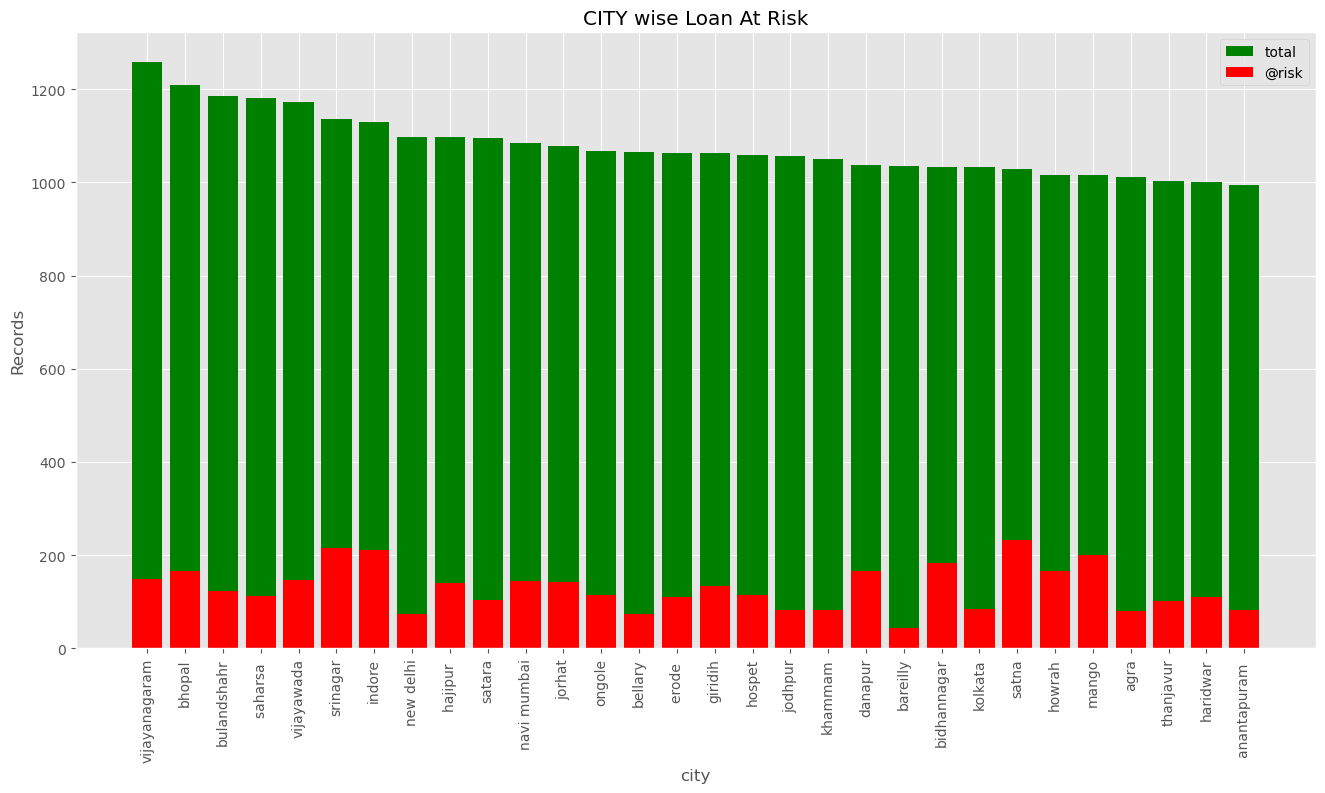

Top 5 with Least Default Rate: CITY
          city  risk_flag  total_records  Average_@risk
34    bareilly         44           1036       0.042471
214  new delhi         74           1098       0.067395
38     bellary         73           1065       0.068545
139    jodhpur         82           1056       0.077652
154    khammam         82           1051       0.078021
Top 5 with Most Default Rate: CITY
            city  risk_flag  total_records  Average_@risk
57   bidhannagar        184           1033       0.178122
126       indore        212           1130       0.187611
281     srinagar        216           1136       0.190141
184        mango        200           1016       0.196850
263        satna        232           1028       0.225681


In [ ]:
univariate_barplot(df, 'city', 'risk_flag',top=30)

In [ ]:
state_group_df =df.groupby(['state','city'])['risk_flag'].agg('mean').sort_values(ascending=False).to_frame()
print('Top 5 Cities with their respective states and default rates')
print(state_group_df.head())
print("="*50)
print('Least 5 Cities with their respective states and default rates')
print(state_group_df.tail())

Top 5 Cities with their respective states and default rates
                            risk_flag
state          city                  
odisha         bhubaneswar   0.326194
madhya pradesh gwalior       0.272727
bihar          bettiah       0.266958
kerala         kochi         0.252862
west bengal    raiganj       0.239554
Least 5 Cities with their respective states and default rates
                              risk_flag
state       city                       
karnataka   bangalore          0.037139
            bijapur            0.034965
delhi       sultan pur majra   0.034091
uttarakhand dehradun           0.026346
gujarat     gandhinagar        0.026114


**Observations**
- There are more than 317 unique cities in our dataset
- We see satna has over 232 risk Flag against 1028 total records which produces highest default rate of 22.56%.
- The highest records are coming from the vijayanagaram over 1200+ and the average records from each city are 795 approx.
- The statewise distribution stats gives us better picture, we see the city bhubaneswar from the state odisha has over 32.6% default rate. from madhya pradesh, the gwalior city has over 27.27%. these indicates that from state Madhya pradesh over 27.2% default are coming from gwalior city only and same with other records.
- We see some city has very less default rate like bareilly of 4%, New Delhi of 6%.

## Profession

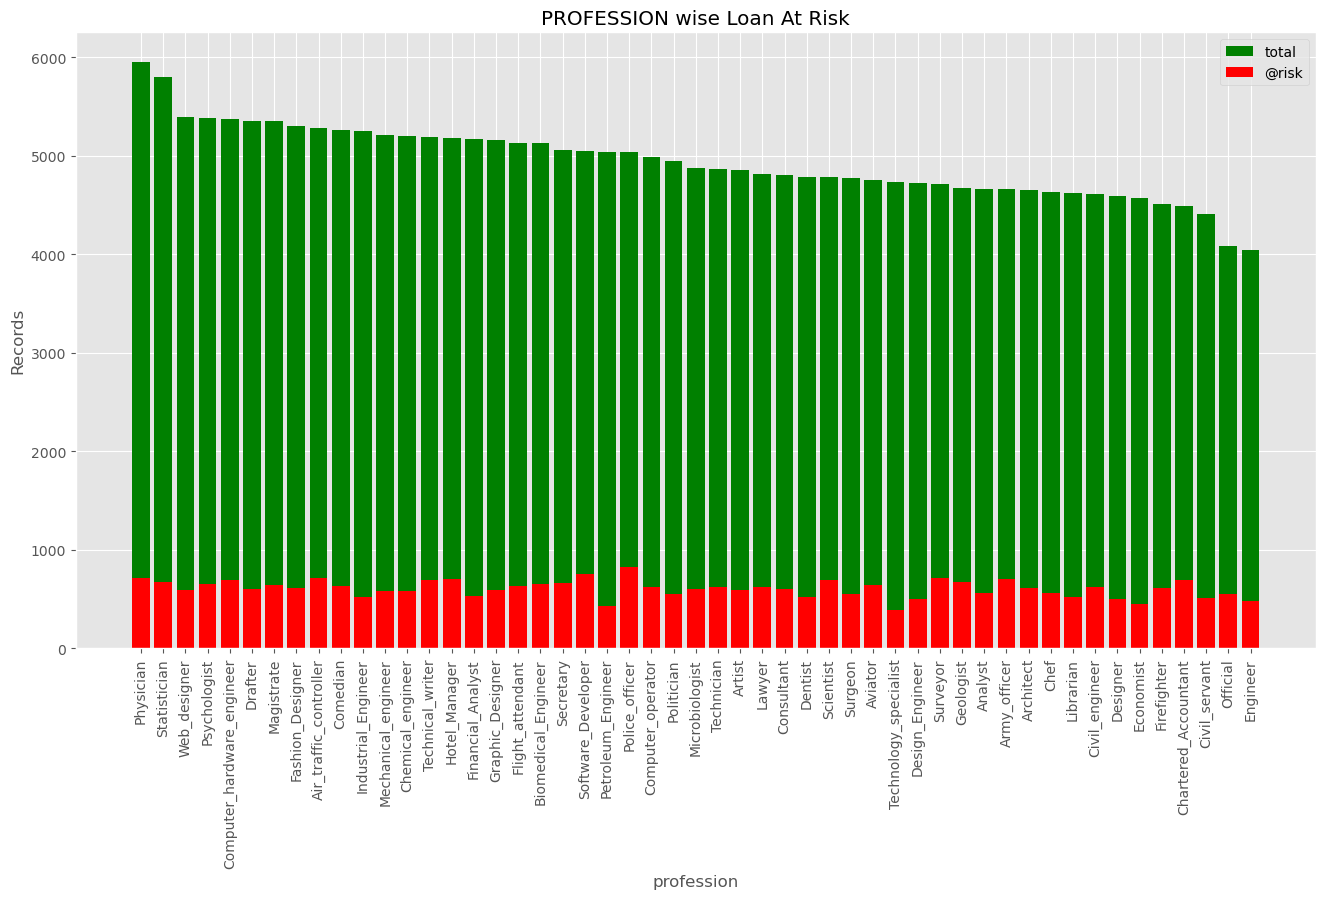

Top 5 with Least Default Rate: PROFESSION
               profession  risk_flag  total_records  Average_@risk
49  Technology_specialist        386           4737       0.081486
36     Petroleum_Engineer        429           5041       0.085102
29    Industrial_Engineer        518           5250       0.098667
20              Economist        454           4573       0.099278
23      Financial_Analyst        533           5167       0.103155
Top 5 with Most Default Rate: PROFESSION
              profession  risk_flag  total_records  Average_@risk
43    Software_Developer        750           5053       0.148427
46              Surveyor        714           4714       0.151464
3           Army_officer        709           4661       0.152113
7   Chartered_Accountant        690           4493       0.153572
38        Police_officer        826           5035       0.164052


In [ ]:
univariate_barplot(df, 'profession', 'risk_flag')

**Observations**
- The Profession, one of the most important feature in risk identification, There are more than 51 unique proefession were physician and statistician has most records over 6000 approx. in our dataset.
- Customers like, Who serving for the nation like Police officers and Army officer has higher default rate of 16.4% and 15.3% these profession people were get died while doing there duties which result in these numbers of loan default.
- But Software Developers and C.A . categories has also over 14.8% and 15.21% default rate which seems quite unsual as these people were has higher salary pay.
- Surveyor are the people who measure land features show about 15.1% default rate.


## Years of Experience

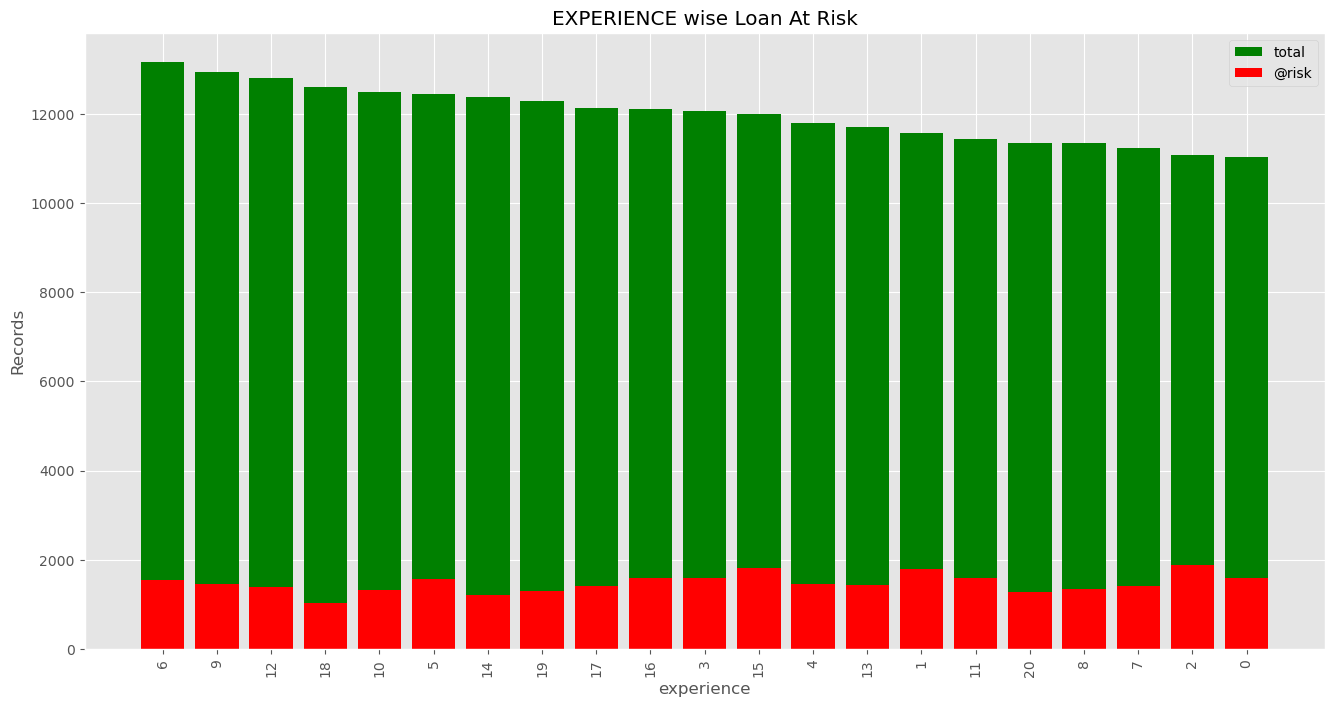

Top 5 with Least Default Rate: EXPERIENCE
    experience  risk_flag  total_records  Average_@risk
18          18       1029          12601       0.081660
14          14       1212          12369       0.097987
10          10       1315          12503       0.105175
19          19       1305          12287       0.106210
12          12       1396          12800       0.109063
Top 5 with Most Default Rate: EXPERIENCE
    experience  risk_flag  total_records  Average_@risk
11          11       1584          11449       0.138353
0            0       1582          11043       0.143258
15          15       1808          11993       0.150755
1            1       1802          11575       0.155680
2            2       1890          11087       0.170470


In [ ]:
univariate_barplot(df, query_col='experience',targate_col='risk_flag')

**Observations**
- The Customer Experiance ranges (0 - 20) Years with Average Experiance of 10.08 Years.
- We can clearly see The customers with double digit experiance has least default rate expect some cases like 11 and 15
- Customer like 0 to 2 has higher default rate over 14.3%, 15.56% and 17.04% .
- This indicate customers with very less experiance in their profession are at higher risk of default.

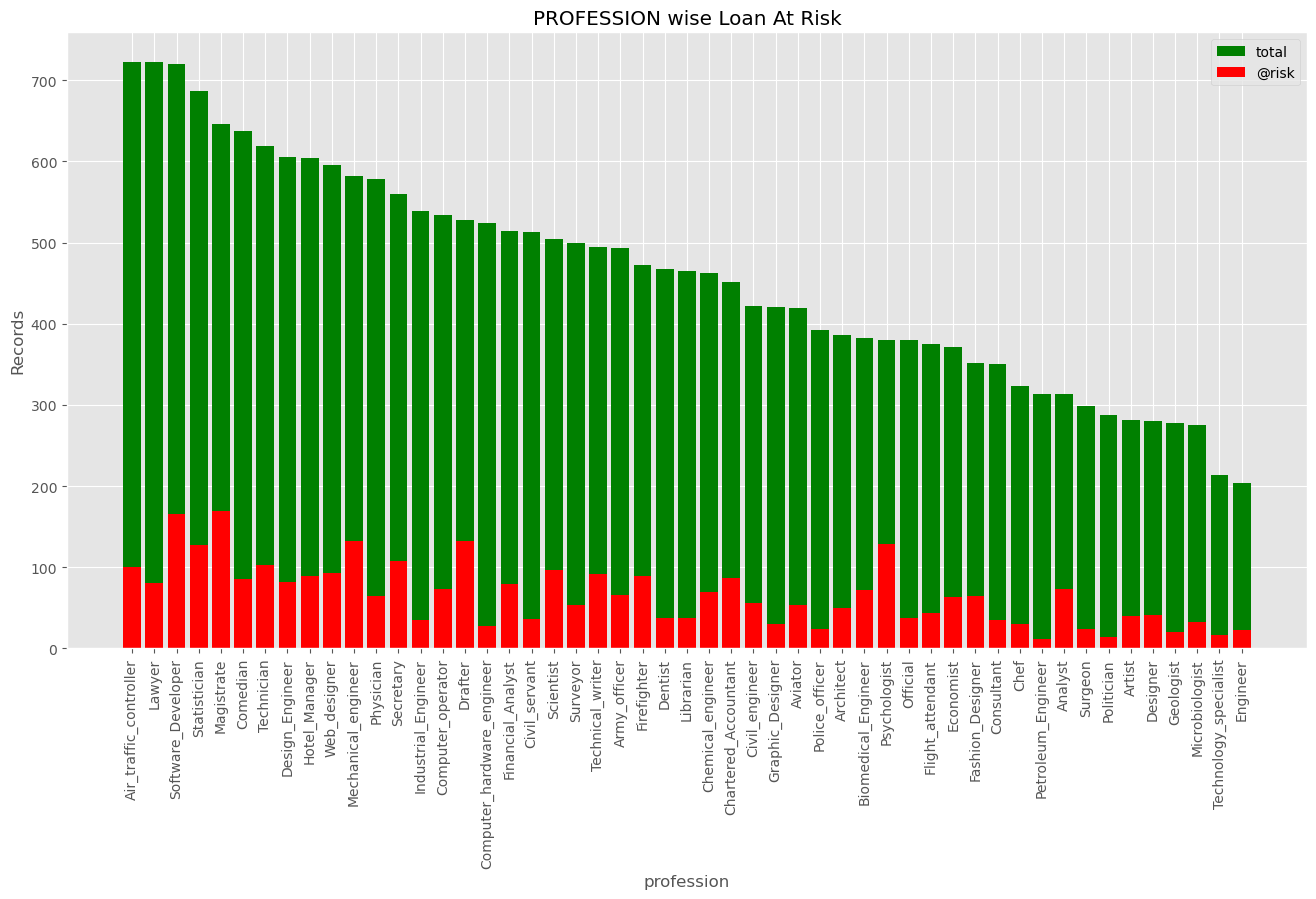

Top 5 with Least Default Rate: PROFESSION
                    profession  risk_flag  total_records  Average_@risk
36          Petroleum_Engineer         12            313       0.038339
39                  Politician         14            288       0.048611
13  Computer_hardware_engineer         28            524       0.053435
38              Police_officer         24            392       0.061224
29         Industrial_Engineer         35            539       0.064935
Top 5 with Most Default Rate: PROFESSION
            profession  risk_flag  total_records  Average_@risk
43  Software_Developer        165            720       0.229167
1              Analyst         73            313       0.233227
19             Drafter        132            528       0.250000
32          Magistrate        169            646       0.261610
40        Psychologist        129            380       0.339474
records : (23442, 13)


In [ ]:
# lets see the professions of 11 years experiance and 15 years experiance
profession_11_and_15 = df[(df['experience']==11) | (df['experience']==15)]
univariate_barplot(data=profession_11_and_15, query_col='profession', targate_col='risk_flag')
print('records :',profession_11_and_15.shape)

**Observations**
- There ae more than 23K customers with 11 and 15 years of experiance
- The professions like Psychologist Magistrate and Drafter has over 28% Average Combined default rate.
- Still didn't get why this category customers has high default rate as these professions has quite good wealth.

## Annual Income

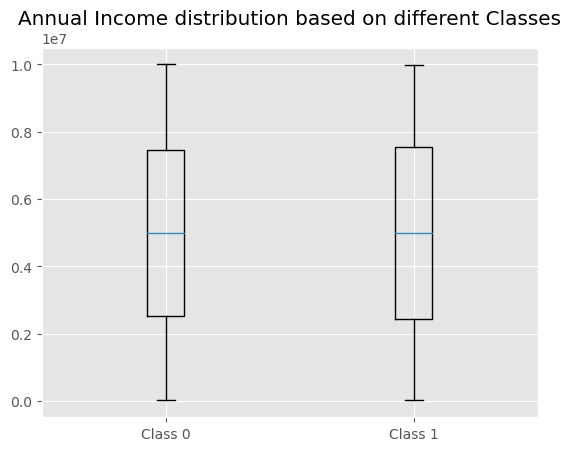

In [ ]:
# income --- box plot
risk_flag_income = df[df['risk_flag'] == 1]['income']
not_risk_flag_income = df[df['risk_flag']==0]['income']
plt.boxplot([not_risk_flag_income,risk_flag_income])
plt.title('Annual Income distribution based on different Classes')
plt.xticks([1,2],('Class 0','Class 1'))
plt.show()

In [ ]:
print('Mean Annual Income for Class 0: ', round(df[df['risk_flag'] == 0]['income'].mean()))
print('Mean Annual Income for Class 1: ', round(df[df['risk_flag'] == 1]['income'].mean()))

Mean Annual Income for Class 0:  5000449
Mean Annual Income for Class 1:  4973359


**Observations**
- The Box plot highly similar for both classes with no outliers.

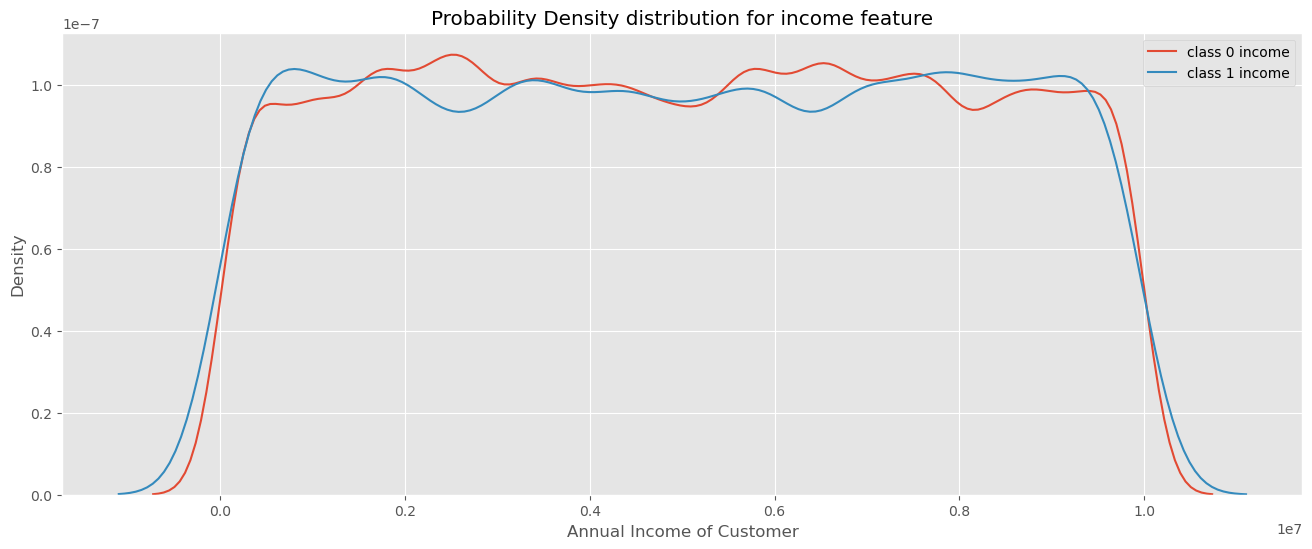

In [ ]:

plt.figure(figsize=(16,6))
sns.distplot(not_risk_flag_income,hist=False, label='class 0 income')
sns.distplot(risk_flag_income,hist=False, label='class 1 income')
plt.legend()
plt.title('Probability Density distribution for income feature')
plt.xlabel('Annual Income of Customer')
plt.show()

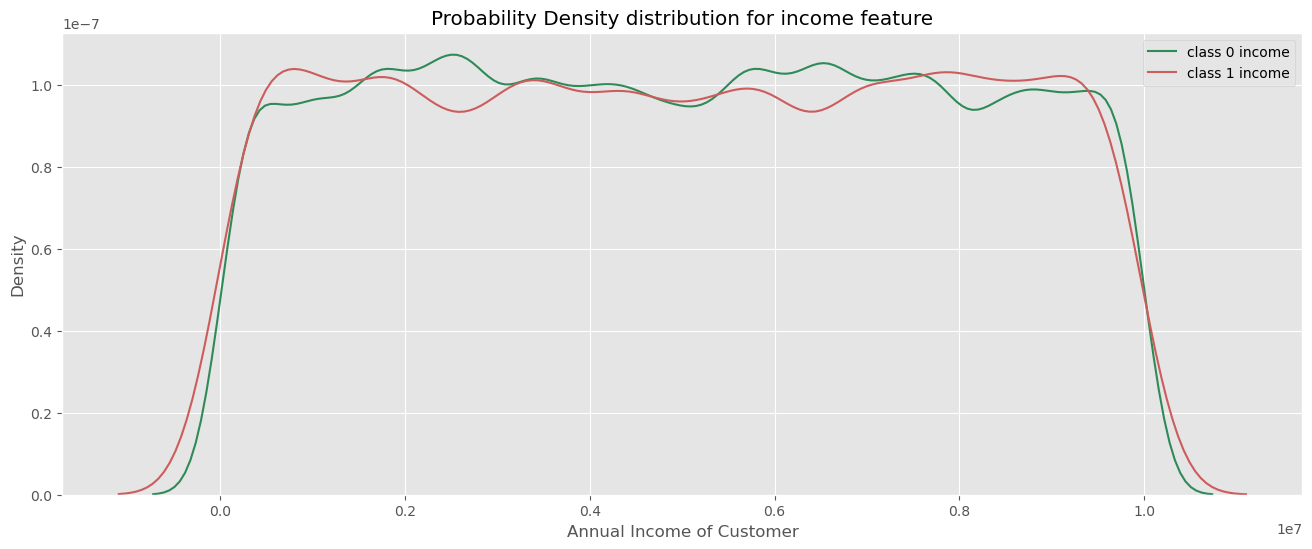

In [ ]:
plt.figure(figsize=(16,6))

# Use colors from the palette for the distplots
sns.distplot(not_risk_flag_income, hist=False, color=palette_colors[0], label='class 0 income')
sns.distplot(risk_flag_income, hist=False, color=palette_colors[1], label='class 1 income')

plt.legend()
plt.title('Probability Density distribution for income feature')
plt.xlabel('Annual Income of Customer')
plt.show()


**Observations**
- There is high overlap between the classes based on the customers income
- This indicates only income feature not enough to differentiat the loan default.

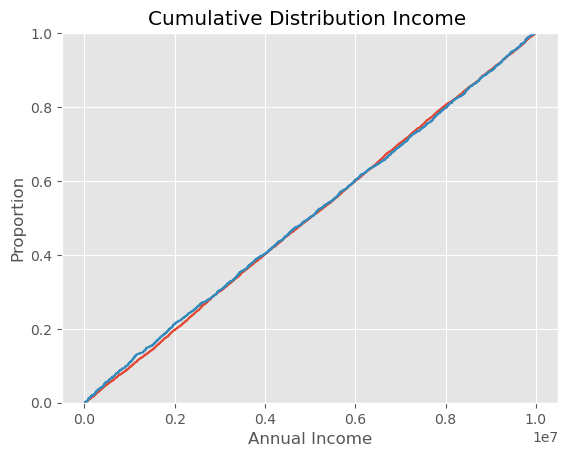

In [ ]:
sns.ecdfplot(not_risk_flag_income)
sns.ecdfplot(risk_flag_income)
plt.title('Cumulative Distribution Income ')
plt.xlabel('Annual Income')
plt.show()

**Observations**
- CDF plot also carry similar information not showning any differentiator between these two classes based on Income.

In [ ]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ['Percentile','Risk Flag 0', 'Risk Flag 1']

for i in range(0, 101, 5):
    x.add_row([i, np.round(np.percentile(not_risk_flag_income, i), 3), np.round(np.percentile(risk_flag_income, i), 3)])
print(x)

+------------+-------------+-------------+
| Percentile | Risk Flag 0 | Risk Flag 1 |
+------------+-------------+-------------+
|     0      |   10310.0   |   10675.0   |
|     5      |   510754.0  |  431968.75  |
|     10     |  1044096.0  |   927040.0  |
|     15     |  1568292.0  |  1415711.0  |
|     20     |  2036508.0  |  1885923.0  |
|     25     |  2520632.75 |  2421029.0  |
|     30     |  2976480.0  |  2946448.0  |
|     35     |  3477314.0  |  3423478.0  |
|     40     |  3983577.8  |  3957826.0  |
|     45     |  4485310.0  |  4445947.0  |
|     50     |  5002134.0  |  4977653.0  |
|     55     |  5535576.0  |  5510977.75 |
|     60     |  6000177.0  |  5979323.0  |
|     65     |  6490702.0  |  6550245.75 |
|     70     |  6967997.0  |  7055950.0  |
|     75     |  7470480.0  |  7556052.0  |
|     80     |  7946836.0  |  8022038.0  |
|     85     |  8486446.0  |  8512476.0  |
|     90     |  8996641.0  |  9038552.0  |
|     95     |  9508705.0  |  9475430.0  |
|    100   

## Current Job Years

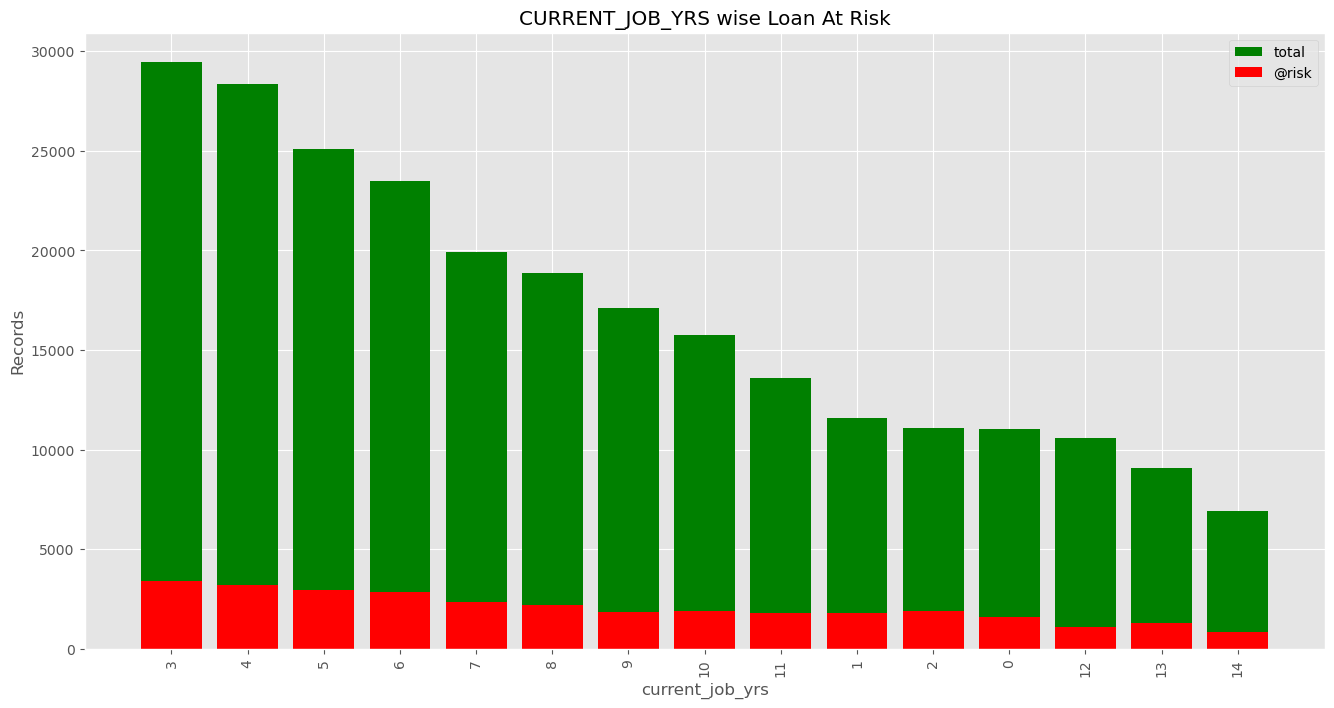

Top 5 with Least Default Rate: CURRENT_JOB_YRS
    current_job_yrs  risk_flag  total_records  Average_@risk
12               12       1116          10605       0.105233
9                 9       1850          17132       0.107985
4                 4       3207          28339       0.113166
8                 8       2181          18874       0.115556
3                 3       3411          29460       0.115784
Top 5 with Most Default Rate: CURRENT_JOB_YRS
    current_job_yrs  risk_flag  total_records  Average_@risk
11               11       1802          13595       0.132549
13               13       1271           9099       0.139686
0                 0       1582          11043       0.143258
1                 1       1802          11575       0.155680
2                 2       1890          11087       0.170470


In [ ]:
univariate_barplot(query_col='current_job_yrs',targate_col='risk_flag', data=df)

**Observations**
- This feature is highly similar to the Experiance.
- Again customers with job years between 0 to 2 have higher default rate over 17.04% maximum.
- The Current Job years range between 0 to 14.
- Overall 30% customers having current job years between 3 to 5

<Figure size 1000x600 with 0 Axes>

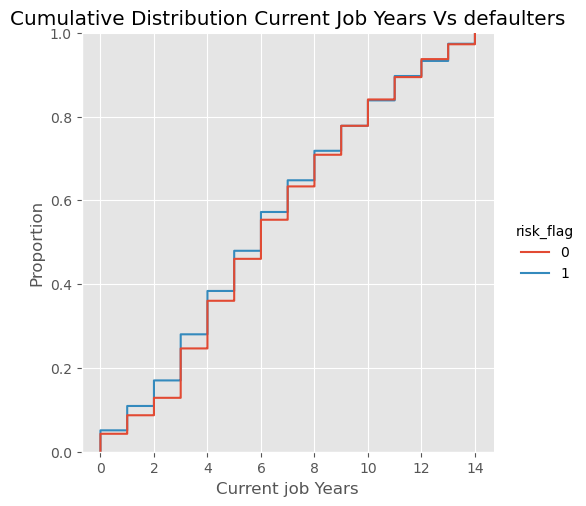

In [ ]:
plt.figure(figsize=(10,6))
sns.displot(x='current_job_yrs', hue='risk_flag', data=df, kind='ecdf')
plt.title('Cumulative Distribution Current Job Years Vs defaulters')
plt.xlabel('Current job Years')
plt.show()

## Current House Years

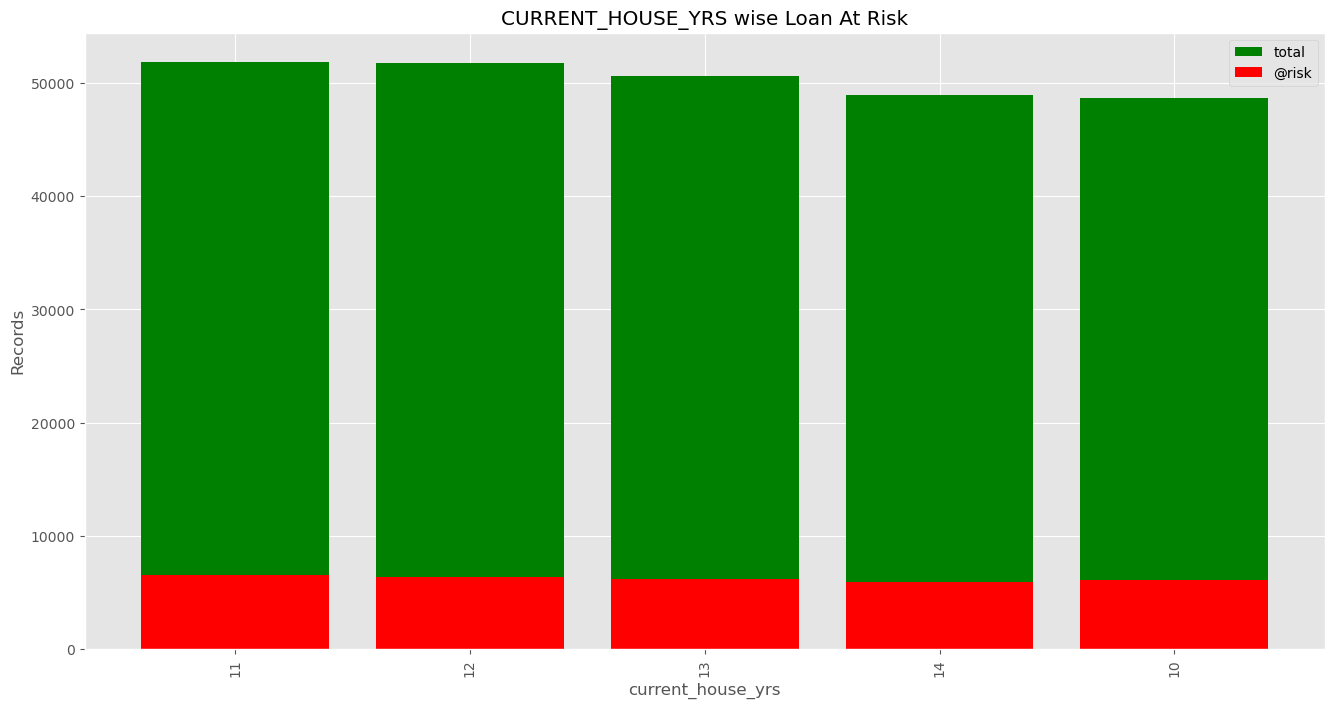

Top 5 with Least Default Rate: CURRENT_HOUSE_YRS
   current_house_yrs  risk_flag  total_records  Average_@risk
4                 14       5945          49003       0.121319
2                 12       6304          51791       0.121720
3                 13       6182          50659       0.122032
0                 10       6082          48674       0.124954
1                 11       6483          51873       0.124978
Top 5 with Most Default Rate: CURRENT_HOUSE_YRS
   current_house_yrs  risk_flag  total_records  Average_@risk
4                 14       5945          49003       0.121319
2                 12       6304          51791       0.121720
3                 13       6182          50659       0.122032
0                 10       6082          48674       0.124954
1                 11       6483          51873       0.124978


In [ ]:
univariate_barplot(query_col='current_house_yrs',targate_col='risk_flag', data=df, top=5)

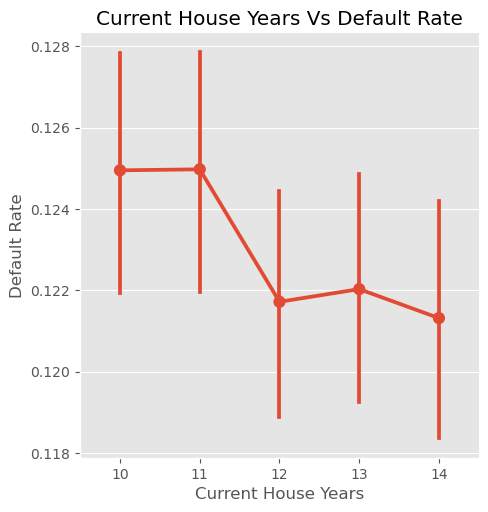

In [ ]:
# sns.factorplot(x='current_house_yrs',y='risk_flag',data=df)sns.catplot(x="current_house_yrs", y="risk_flag", hue="another_column", data=df, kind="bar")
sns.catplot(x="current_house_yrs", y="risk_flag", data=df, kind="point")
plt.title('Current House Years Vs Default Rate')
plt.ylabel('Default Rate')
plt.xlabel('Current House Years')
plt.show()

**Observation**
- We have only 5 unique values for number of years living in the house from 10 to 14.
- The distributions of records and default rate is approximatly similar
- From the 2nd plot we see minor difference of 0.2% between years 10, 11 to years 12, 13, 14 in default rate.

## House Ownership Vs Car Ownership

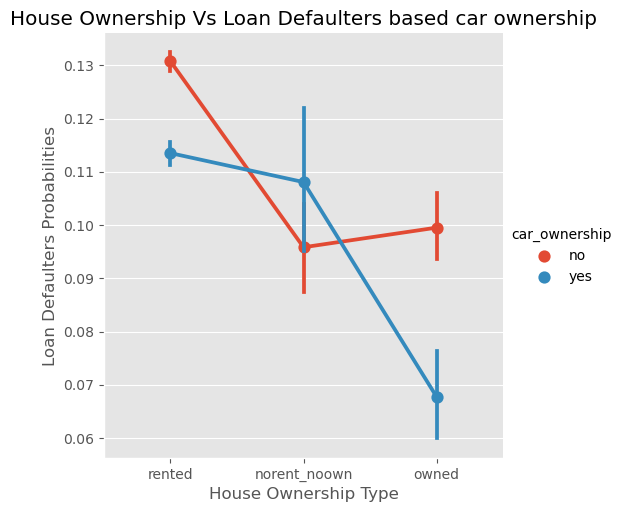

In [ ]:
sns.catplot(x='house_ownership',y='risk_flag',hue='car_ownership',data=df, kind="point")
plt.title('House Ownership Vs Loan Defaulters based car ownership')
plt.xlabel('House Ownership Type')
plt.ylabel('Loan Defaulters Probabilities')
plt.show()

In [ ]:
data_stats(df,'car_ownership', 'risk_flag', columns_list=['house_ownership'])


Total defaulters based on car_ownership 

risk_flag           0      1     All
car_ownership                       
no             153439  22561  176000
yes             67565   8435   76000
All            221004  30996  252000
Proportion of defaulters based on car_ownership 

house_ownership  norent_noown     owned    rented
car_ownership                                    
no                   0.095836  0.099520  0.130776
yes                  0.108083  0.067762  0.113523


**Observations**
- Customers with rented house and having No car have higher default rate 13.0% comparing to customers with rented house and having car 11%
- Customers with own house an having no car have default rate of 9% which higher than having from customer having own house and have own car of 6%
- But Customers have living in house with no rent/ no own have default rate of 9% to 10% having no car or having Car which not significant difference.
- This Analysis gives some differentiation for risk flag 0 and 1.

## House Ownership Vs Marital Status

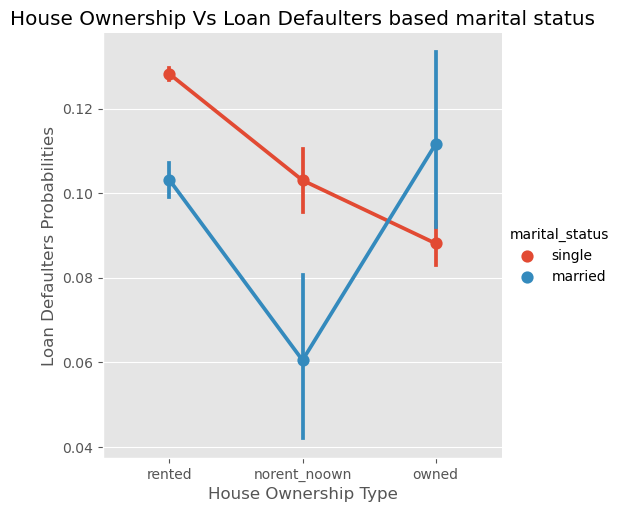

In [ ]:
sns.catplot(x='house_ownership',y='risk_flag',hue='marital_status',data=df, kind="point")
plt.title('House Ownership Vs Loan Defaulters based marital status')
plt.xlabel('House Ownership Type')
plt.ylabel('Loan Defaulters Probabilities')
plt.show()

In [ ]:
data_stats(df, 'house_ownership','risk_flag', columns_list=['marital_status'])

Total defaulters based on house_ownership 

risk_flag             0      1     All
house_ownership                       
norent_noown       6469    715    7184
owned             11758   1160   12918
rented           202777  29121  231898
All              221004  30996  252000
Proportion of defaulters based on house_ownership 

marital_status    married    single
house_ownership                    
norent_noown     0.060504  0.103051
owned            0.111593  0.088120
rented           0.103139  0.128192


**Observations**
- We see the significant difference in default rate for rented and no rent/ no own on basis of their marital status.
- If customers is single and lives in ranted house has higher chances of loan default over 12%.
- If customers is married and lives in no rent / no own house has lesser chances of loan default over 6%.
- Customer with Marital status as Single show slightly higher default rate irrespective their house ownership.


## Age Type Vs Marital Status

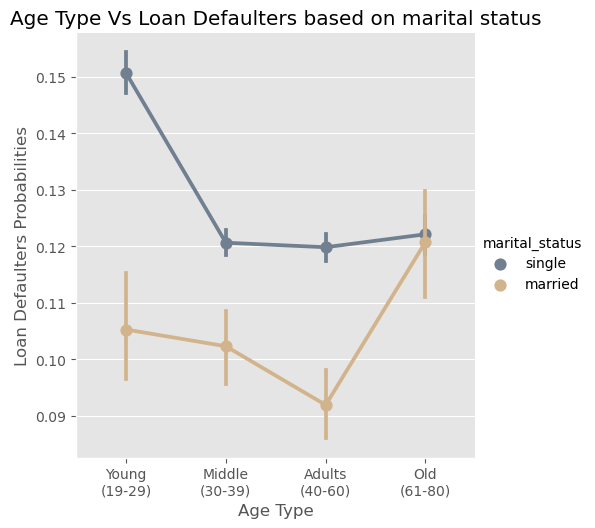

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the color palette based on marital status
palette_colors = {
    'single': '#708090',
    'married': '#D2B48C',
    # Add or modify as per your data's unique values
}

# Create the plot and get the axis object
g = sns.catplot(x='age_type', y='risk_flag', hue='marital_status', data=df, kind="point", palette=palette_colors)
ax = g.axes[0,0]

# Specify the tick locations
xtick_locations = [0, 1, 2, 3]

# Specify the tick labels with age type and age range
xtick_labels = ['Young\n(19-29)', 'Middle\n(30-39)', 'Adults\n(40-60)', 'Old\n(61-80)']

# Set the tick locations and labels
ax.set_xticks(xtick_locations)
ax.set_xticklabels(xtick_labels)

# Set title and axis labels
plt.title('Age Type Vs Loan Defaulters based on marital status')
plt.xlabel('Age Type')
plt.ylabel('Loan Defaulters Probabilities')

# Display the plot
plt.show()


In [ ]:
data_stats(df, 'age_type','risk_flag', columns_list=['marital_status'])

Total defaulters based on age_type 

risk_flag       0      1     All
age_type                        
Adults      36636   5091   41727
Middle      79540  10732   90272
Young       33460   5729   39189
old         71368   9444   80812
All        221004  30996  252000
Proportion of defaulters based on age_type 

marital_status   married    single
age_type                          
Adults          0.120787  0.122152
Middle          0.102344  0.120659
Young           0.105304  0.150687
old             0.091957  0.119860


**Observations**
- Customers with Marital status Married tend to lower default rate as compare to Single.
- Customers of Youger age and marital status single tend to have higher default rate of 15%

## Age Type Vs Car Ownership

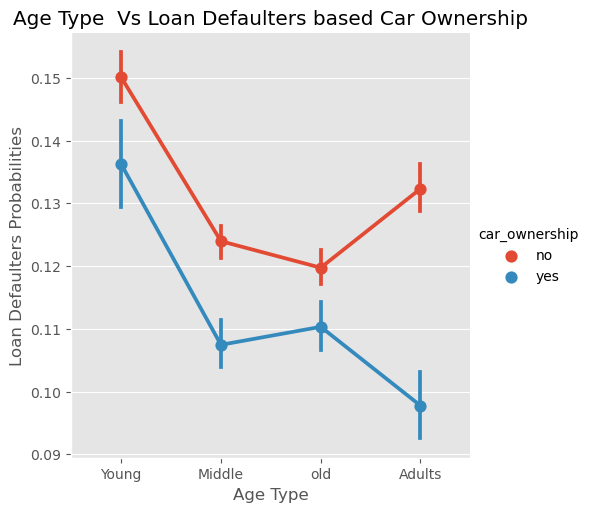

In [ ]:
sns.catplot(x='age_type',y='risk_flag',hue='car_ownership',data=df, kind="point")
plt.title('Age Type  Vs Loan Defaulters based Car Ownership')
plt.xlabel('Age Type')
plt.ylabel('Loan Defaulters Probabilities')
plt.show()

In [ ]:
data_stats(df, 'age_type','risk_flag', columns_list=['car_ownership'])

Total defaulters based on age_type 

risk_flag       0      1     All
age_type                        
Adults      36636   5091   41727
Middle      79540  10732   90272
Young       33460   5729   39189
old         71368   9444   80812
All        221004  30996  252000
Proportion of defaulters based on age_type 

car_ownership        no       yes
age_type                         
Adults         0.132329  0.097761
Middle         0.123968  0.107456
Young          0.150092  0.136253
old            0.119743  0.110324


**Observations**
- We clear that customers based on their Age Type having no car has higher default rate in every Age Type Category.
- After all the analysis we see Younger Age customers are at higher risk of loan default

## Correlations Plot

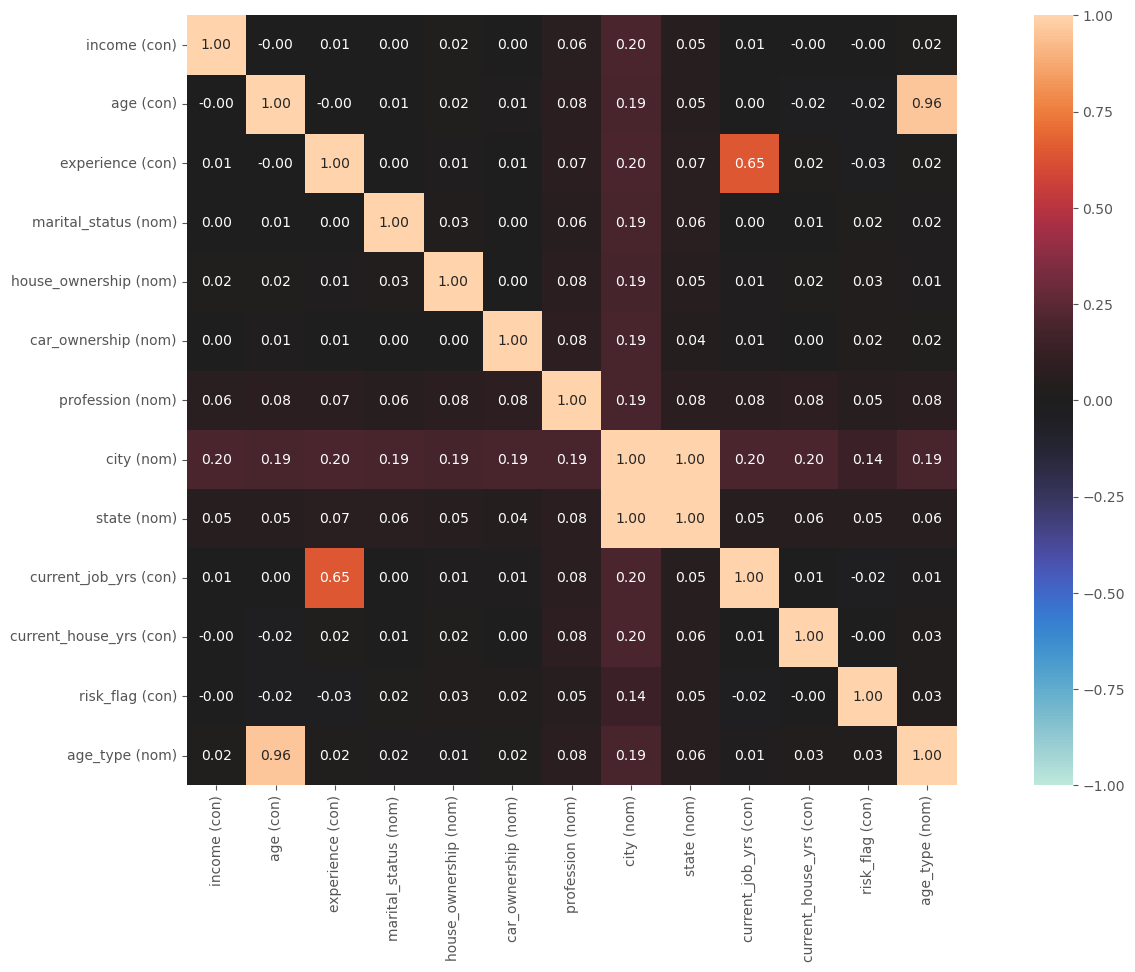

{'corr':                          income (con)  age (con)  experience (con)  \
 income (con)                 1.000000  -0.000652          0.006422   
 age (con)                   -0.000652   1.000000         -0.001118   
 experience (con)             0.006422  -0.001118          1.000000   
 marital_status (nom)         0.002682   0.005323          0.001752   
 house_ownership (nom)        0.019824   0.018865          0.014092   
 car_ownership (nom)          0.004068   0.009395          0.007519   
 profession (nom)             0.064937   0.076105          0.072608   
 city (nom)                   0.196101   0.194821          0.201283   
 state (nom)                  0.051092   0.049829          0.069124   
 current_job_yrs (con)        0.007045   0.002154          0.646098   
 current_house_yrs (con)     -0.002397  -0.020134          0.019309   
 risk_flag (con)             -0.003091  -0.021809         -0.034523   
 age_type (nom)               0.017363   0.955515          0.022758  

In [ ]:
from dython import nominal
nominal.associations(df, figsize=(20, 10), mark_columns=True)

**Observations**
- Feature like current_job_yrs and experiance carry similar informations and hense show higher correlation

In [ ]:
df.to_csv('preprocessed_data.csv', index=False)

In [ ]:
print(df.columns)

Index(['income', 'age', 'experience', 'marital_status', 'house_ownership',
       'car_ownership', 'profession', 'city', 'state', 'current_job_yrs',
       'current_house_yrs', 'risk_flag', 'age_type'],
      dtype='object')


In [ ]:
df = pd.read_csv('preprocessed_data.csv')
df.head()

,income,age,experience,marital_status,house_ownership,car_ownership,profession,city,state,current_job_yrs,current_house_yrs,risk_flag,age_type
0,1303834,23,3,single,rented,no,Mechanical_engineer,rewa,madhya pradesh,3,13,0,Young
1,7574516,40,10,single,rented,no,Software_Developer,parbhani,maharashtra,9,13,0,Middle
2,3991815,66,4,married,rented,no,Technical_writer,alappuzha,kerala,4,10,0,old
3,6256451,41,2,single,rented,yes,Software_Developer,bhubaneswar,odisha,2,12,1,Middle
4,5768871,47,11,single,rented,no,Civil_servant,tiruchirappalli,tamil nadu,3,14,1,Middle


In [ ]:
df.shape

(252000, 13)

## Train Test Split

In [ ]:
X = df.drop(['risk_flag'], axis=1)
y = df['risk_flag']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, random_state=42, test_size=0.25)
print('Training data in hand :', X_train.shape, y_train.shape)
print('Test data in hand :', X_test.shape, y_test.shape)

Training data in hand : (189000, 12) (189000,)
Test data in hand : (63000, 12) (63000,)


In [ ]:
X_train.to_csv('training_data.csv',index=False)
y_train.to_csv('training_target.csv', index=False)

In [ ]:
X_test.to_csv('test_data.csv',index=False)
y_test.to_csv('test_target.csv',index=False)

In [ ]:
print('Class Distribution in Training data class 0:',round((y_train.value_counts()[0] / y_train.shape[0])*100), '%')
print('Class Distribution in Training data class 1:',round((y_train.value_counts()[1] / y_train.shape[0])*100), '%')

Class Distribution in Training data class 0: 88 %
Class Distribution in Training data class 1: 12 %


## Feature Engineering and Encoding

In [ ]:
# Let's remove current_job_yrs based on EDA, as current_job_yrs and experiance are carring same informations
# remove the id column as it not required for final modeling
df.drop('current_job_yrs', axis=1, inplace=True)
df.shape

(252000, 12)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   income             252000 non-null  int64 
 1   age                252000 non-null  int64 
 2   experience         252000 non-null  int64 
 3   marital_status     252000 non-null  object
 4   house_ownership    252000 non-null  object
 5   car_ownership      252000 non-null  object
 6   profession         252000 non-null  object
 7   city               252000 non-null  object
 8   state              252000 non-null  object
 9   current_house_yrs  252000 non-null  int64 
 10  risk_flag          252000 non-null  int64 
 11  age_type           252000 non-null  object
dtypes: int64(5), object(7)
memory usage: 23.1+ MB


In [ ]:
df.nunique()

income               41920
age                     59
experience              21
marital_status           2
house_ownership          3
car_ownership            2
profession              51
city                   317
state                   28
current_house_yrs        5
risk_flag                2
age_type                 4
dtype: int64

## Lets Perform response encoding for Categorical Feature Having Unique Values > 5

In [ ]:
def fit_response_encoding(alpha, feature):
    # get the frequency of each category in feature
    data_values = X_train[feature].value_counts()
    feat_dict = {}
    # compute class probability for each category
    for value, total_occurence in data_values.items():
        class_proba_vector = []
        for _class in range(0, 2):

            # find total occurence of a class for each category
            class_occurence = len(X_train.loc[(X_train[feature] == value) & (y_train == _class)])
            # compute the  class probability with respect to category in feature with small value alpha (laplace smoothing term)
            class_value_proba = (class_occurence + alpha *10) /  ( total_occurence + alpha*20)
            # append the probability of each class w.r.t. category in feature
            class_proba_vector.append(class_value_proba)
        # store the result vector in master dictionary
        feat_dict[value] = class_proba_vector
    return feat_dict

In [ ]:
def transform_response_encoding(alpha, feature, data):
    # store the probability of each class w.r.t. category feature
    result_feature = []
    # get probability from training data of each class w.r.t. category in feature
    feature_proba = fit_response_encoding(alpha, feature)
    # for each data row
    for category in data:
        # if category found in probability dictionary
        if category in feature_proba.keys():
            result_feature.append(feature_proba[category])
        else:
            # if not category found
            result_feature.append([0.5,0.5])
    return np.array(result_feature)

- Response Encoding State Feature

In [ ]:
X_train_state_re = transform_response_encoding(alpha=1, feature='state',data=X_train.state.values)
X_test_state_re = transform_response_encoding(alpha=1, feature='state', data=X_test.state.values)

print('after response encoding ...')
print(X_train_state_re.shape, y_train.shape)
print(X_test_state_re.shape, y_test.shape)

after response encoding ...
(189000, 2) (189000,)
(63000, 2) (63000,)


- Response Encoding City Feature

In [ ]:
X_train_city_re = transform_response_encoding(alpha=1, feature='city',data=X_train.city.values)
X_test_city_re = transform_response_encoding(alpha=1, feature='city', data=X_test.city.values)

print('after response encoding ...')
print(X_train_city_re.shape, y_train.shape)
print(X_test_city_re.shape, y_test.shape)

after response encoding ...
(189000, 2) (189000,)
(63000, 2) (63000,)


- Response Encoding Profession Feature

In [ ]:
X_train_profession_re = transform_response_encoding(alpha=1, feature='city',data=X_train.profession.values)
X_test_profession_re = transform_response_encoding(alpha=1, feature='city', data=X_test.profession.values)

print('after response encoding ...')
print(X_train_profession_re.shape, y_train.shape)
print(X_test_profession_re.shape, y_test.shape)

after response encoding ...
(189000, 2) (189000,)
(63000, 2) (63000,)


## Label Encoding Feature
- House Ownership
- Car Ownership
- Marital Status
- Age Type

Lets encode based on mode e.g. for highest occurence 0 then second highest 1 and so on.


- House Ownership Label Encoding

In [ ]:
X_train.house_ownership.value_counts()

rented          173829
owned             9783
norent_noown      5388
Name: house_ownership, dtype: int64

In [ ]:
X_train['house_ownership'] = X_train['house_ownership'].map({'rented':0, 'owned':1, 'norent_noown':2})
X_test['house_ownership'] = X_test['house_ownership'].map({'rented':0, 'owned':1, 'norent_noown':2})

In [ ]:
X_train.house_ownership.value_counts()

0    173829
1      9783
2      5388
Name: house_ownership, dtype: int64

- Car Ownership Label Encoding

In [ ]:
X_train.car_ownership.value_counts()

no     132375
yes     56625
Name: car_ownership, dtype: int64

In [ ]:
X_train['car_ownership'] = X_train['car_ownership'].map({'no':0, 'yes':1})
X_test['car_ownership'] = X_test['car_ownership'].map({'no':0, 'yes':1})

In [ ]:
X_train.car_ownership.value_counts()

0    132375
1     56625
Name: car_ownership, dtype: int64

- Marital Status Label Encoding

In [ ]:
X_train.marital_status.value_counts()

single     169783
married     19217
Name: marital_status, dtype: int64

In [ ]:
X_train['marital_status'] = X_train['marital_status'].map({'single':0, 'married':1})
X_test['marital_status'] = X_test['marital_status'].map({'single':0, 'married':1})

In [ ]:
X_train.marital_status.value_counts()

0    169783
1     19217
Name: marital_status, dtype: int64

- Age Type Label Encoding

In [ ]:
X_train.age_type.value_counts()

Middle    67603
old       60811
Adults    31321
Young     29265
Name: age_type, dtype: int64

In [ ]:
X_train['age_type'] = X_train['age_type'].map({'Middle':0, 'old':1, 'Adults':2, 'Young':3})
X_test['age_type'] = X_test['age_type'].map({'Middle':0, 'old':1, 'Adults':2, 'Young':3})

In [ ]:
X_train.age_type.value_counts()

0    67603
1    60811
2    31321
3    29265
Name: age_type, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   income             252000 non-null  int64 
 1   age                252000 non-null  int64 
 2   experience         252000 non-null  int64 
 3   marital_status     252000 non-null  object
 4   house_ownership    252000 non-null  object
 5   car_ownership      252000 non-null  object
 6   profession         252000 non-null  object
 7   city               252000 non-null  object
 8   state              252000 non-null  object
 9   current_house_yrs  252000 non-null  int64 
 10  risk_flag          252000 non-null  int64 
 11  age_type           252000 non-null  object
dtypes: int64(5), object(7)
memory usage: 23.1+ MB


In [ ]:
X_train_remaining_cat_le_features = X_train[['house_ownership','car_ownership','marital_status','age_type']].values
X_test_remaining_cat_le_features = X_test[['house_ownership','car_ownership','marital_status','age_type']].values

## Scaling Numerical Features
- Age
- Experiance
- income
- current house yrs

In [ ]:
# age
normalizer = MinMaxScaler()
normalizer.fit(X_train['age'].values.reshape(-1,1))

X_train_age_norm = normalizer.transform(X_train['age'].values.reshape(-1,1))
X_test_age_norm = normalizer.transform(X_test['age'].values.reshape(-1,1))


print("After vectorizations")
print(X_train_age_norm.shape, y_train.shape)
print(X_test_age_norm.shape, y_test.shape)

After vectorizations
(189000, 1) (189000,)
(63000, 1) (63000,)


In [ ]:
# Experience
normalizer = MinMaxScaler()
normalizer.fit(X_train['experience'].values.reshape(-1,1))

X_train_experience_norm = normalizer.transform(X_train['experience'].values.reshape(-1,1))
X_test_experience_norm = normalizer.transform(X_test['experience'].values.reshape(-1,1))


print("After vectorizations")
print(X_train_experience_norm.shape, y_train.shape)
print(X_test_experience_norm.shape, y_test.shape)

After vectorizations
(189000, 1) (189000,)
(63000, 1) (63000,)


In [ ]:
# income
normalizer = MinMaxScaler()
normalizer.fit(X_train['income'].values.reshape(-1,1))

X_train_income_norm = normalizer.transform(X_train['income'].values.reshape(-1,1))
X_test_income_norm = normalizer.transform(X_test['income'].values.reshape(-1,1))


print("After vectorizations")
print(X_train_income_norm.shape, y_train.shape)
print(X_test_income_norm.shape, y_test.shape)

After vectorizations
(189000, 1) (189000,)
(63000, 1) (63000,)


In [ ]:
# current_house_yrs
normalizer = MinMaxScaler()
normalizer.fit(X_train['current_house_yrs'].values.reshape(-1,1))

X_train_current_house_yrs_norm = normalizer.transform(X_train['current_house_yrs'].values.reshape(-1,1))
X_test_current_house_yrs_norm = normalizer.transform(X_test['current_house_yrs'].values.reshape(-1,1))


print("After vectorizations")
print(X_train_current_house_yrs_norm.shape, y_train.shape)
print(X_test_current_house_yrs_norm.shape, y_test.shape)


After vectorizations
(189000, 1) (189000,)
(63000, 1) (63000,)


In [ ]:
X_train_stack = np.hstack((X_train_state_re, X_train_city_re, X_train_profession_re, X_train_remaining_cat_le_features, X_train_age_norm, X_train_experience_norm,
                         X_train_income_norm, X_train_current_house_yrs_norm))
X_test_stack = np.hstack((X_test_state_re, X_test_city_re, X_test_profession_re, X_test_remaining_cat_le_features, X_test_age_norm, X_test_experience_norm,
                         X_test_income_norm, X_test_current_house_yrs_norm))

In [ ]:
data_columns = ['state_re_0', 'state_re_1', 'city_re_0', 'city_re_1', 'prefession_re_0',
       'profession_re_1', 'house_ownership_le', 'car_ownership_le',
       'marital_status_le', 'age_type_le', 'age_norm', 'experience_norm',
       'income_nrom', 'current_house_yrs_norm']
X_train_stack_df = pd.DataFrame(X_train_stack, columns=data_columns)
X_test_stack_df = pd.DataFrame(X_test_stack, columns=data_columns)


In [ ]:
X_train_stack_df.to_csv('final_training_data.csv')
X_test_stack_df.to_csv('final_test_data.csv')

In [ ]:
y_train.to_csv('final_training_target.csv',index=False)
y_test.to_csv('final_test_target.csv',index=False)

In [ ]:
print('Final training data :', X_train_stack_df.shape, y_train.shape)
print('Final Test data : ', X_test_stack_df.shape, y_test.shape)

Final training data : (189000, 14) (189000,)
Final Test data :  (63000, 14) (63000,)


# Modeling

## Dummy Model

In [ ]:
y_pred_list = []
for value in range(y_test.shape[0]):
    y_pred = random.randint(0,1)
    y_pred_list.append(y_pred)

In [ ]:
y_true = np.array(y_test.values)
print('roc_auc_score for dummy Model is {:.4f}'.format(roc_auc_score(y_true, y_pred_list)))

roc_auc_score for dummy Model is 0.4989


## BaseLine Model

In [ ]:
from sklearn.naive_bayes import GaussianNB
gaussian_model = GaussianNB()
gaussian_model.fit(X_train_stack, y_train)

GaussianNB()

In [ ]:
y_pred = gaussian_model.predict(X_test_stack)
print('roc_auc_score for Baseline  Model is {:.4f}'.format(roc_auc_score(y_true, y_pred)))

roc_auc_score for Baseline  Model is 0.5308


## Feature Selection Based on Feature Importance

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

classifier = RandomForestClassifier(n_estimators=30, n_jobs=-1)
top_features = SelectFromModel(classifier, threshold=-np.inf)
classifier.fit(X_train_stack_df, y_train)

RandomForestClassifier(n_estimators=30, n_jobs=-1)

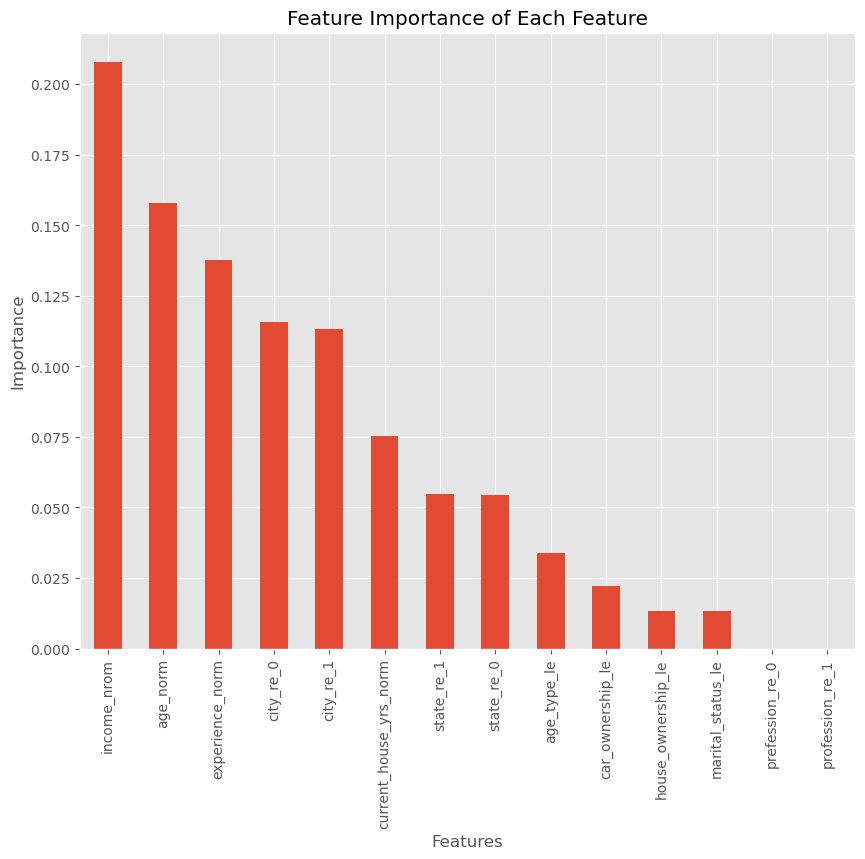

In [ ]:
plt.figure(figsize=(10,8))
plt.title('Feature Importance of Each Feature')
pd.Series(classifier.feature_importances_, index=data_columns).sort_values(ascending=False).plot(kind='bar')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

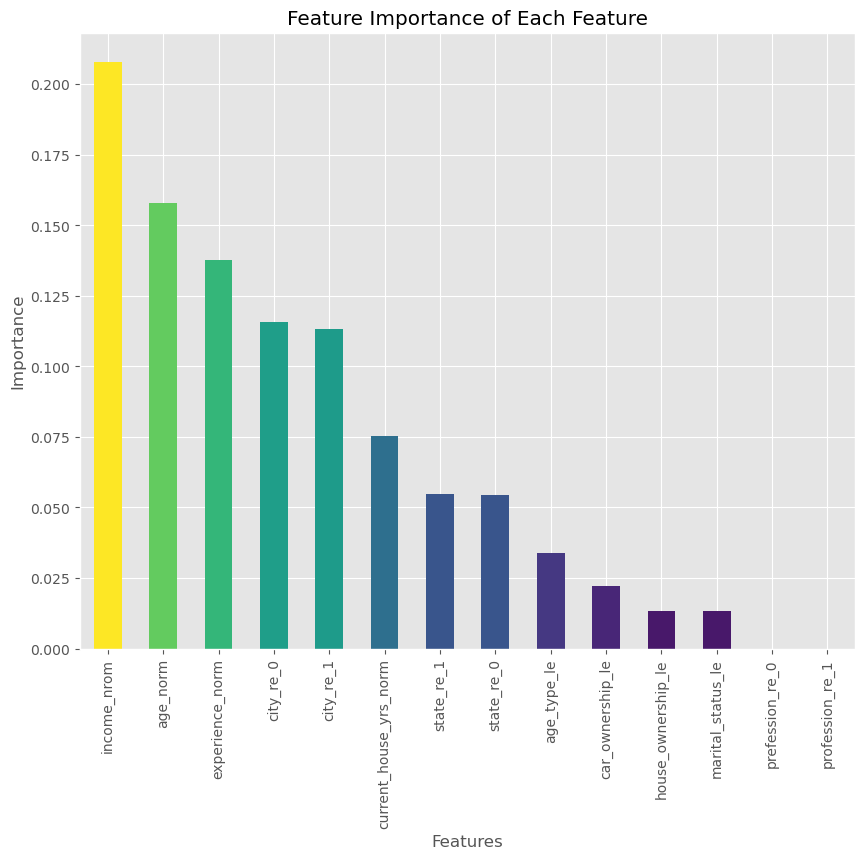

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming classifier.feature_importances_ is already available
feature_importances = pd.Series(classifier.feature_importances_, index=data_columns).sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title('Feature Importance of Each Feature')

# Use the viridis colormap and normalize the importance values to get color intensities
colors = plt.cm.viridis(feature_importances / feature_importances.max())

feature_importances.plot(kind='bar', color=colors)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()


**Observations**
- Feature Profession has no contribution towards predicting the loan default.
- This could be major issue as many of the times customers are asked about their occupations and working while giving loans.
- But at same time their geographical info, experiance they have in their field, their relational status, expenses they own, and major their income has greater contribution to predicting the loan default.

In [ ]:
X_train_stack_df.columns

Index(['state_re_0', 'state_re_1', 'city_re_0', 'city_re_1', 'prefession_re_0',
       'profession_re_1', 'house_ownership_le', 'car_ownership_le',
       'marital_status_le', 'age_type_le', 'age_norm', 'experience_norm',
       'income_nrom', 'current_house_yrs_norm'],
      dtype='object')

In [ ]:
X_train_stack_df.drop(columns=['prefession_re_0','profession_re_1'], axis=1, inplace=True)
X_test_stack_df.drop(columns=['prefession_re_0','profession_re_1'], axis=1, inplace=True)

In [ ]:
X_train_stack_df.shape, X_test_stack_df.shape

((189000, 12), (63000, 12))

## SMOTE with ENN To tackle data imbalanced problem.
## SMOTE with Tomek To tackle data imbalanced problem.

In [ ]:
from imblearn.combine import SMOTETomek
from collections import Counter

smote_tomek = SMOTETomek()
print('before sampling using smote...', Counter(y_train))
X_train_resample, y_train_resample = smote_tomek.fit_resample(X_train_stack_df, y_train.ravel())
print('after sampling using smote...',Counter(y_train_resample))
X_test_resample , y_test_resample = smote_tomek.fit_resample(X_test_stack_df, y_test.ravel())


before sampling using smote... Counter({0: 165753, 1: 23247})
after sampling using smote... Counter({0: 165288, 1: 165288})


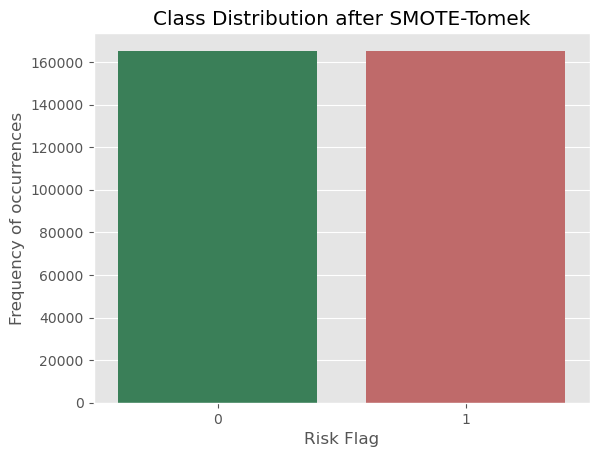

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


palette_colors = {0: '#2E8B57', 1: '#CD5C5C'}
# Convert y_train_resample to a DataFrame
df_resample = pd.DataFrame(y_train_resample, columns=['risk_flag'])

# Create the plot using seaborn
sns.countplot(x='risk_flag', data=df_resample,palette=palette_colors)
plt.xlabel('Risk Flag')
plt.ylabel('Frequency of occurrences')
plt.title('Class Distribution after SMOTE-Tomek')
plt.show()


## Utility functions

In [ ]:
## AAIC
def find_best_threshold(threshould, fpr, tpr):
    """ Find the best probability threshould for seperating class 0 and class 1  """
    t = threshould[np.argmax(tpr*(1-fpr))]

    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t
## AAIC
def predict_with_best_t(proba, threshould):
    """ Make the predections based on selected threshould probability and predicted probability for the record"""
    predictions = []

    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


In [ ]:
## inspiered by AAIC
from sklearn.metrics import roc_curve, auc, classification_report
def plot_evaluations_graphs(model, X_train, X_test, y_train, y_test):
    """ Plot the graphs to evaluate the performance of ML Models  """
    # finding the probabilities from model
    y_train_probs = model.predict_proba(X_train)[:,1]
    y_test_probs= model.predict_proba(X_test )[:,1]

    # extracting the true positive and false positive rates
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_probs)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_probs)

    plt.figure(figsize=(12,8))
    plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("False Positive Rate(FPR)")
    plt.ylabel("True Positive Rate(TPR)")
    plt.title("ROC CURVE with AUC Scores for Trining and test data")
    plt.grid(color='black',lw=0.5)
    plt.show()

    best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
    cm = confusion_matrix(y_train, predict_with_best_t(y_train_probs,best_t))
    print(cm)
    # https://seaborn.pydata.org/generated/seaborn.heatmap.html
    # https://stackoverflow.com/questions/29647749/seaborn-showing-scientific-notation-in-heatmap-for-3-digit-numbers
    sns.heatmap(cm, annot=True,fmt='g' ,cmap="YlGnBu",cbar=True)
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.title('Train Data: Confusion Matrix')
    plt.show()

    ## confusion metrix for test results
    best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)

    cm = confusion_matrix(y_test, predict_with_best_t(y_test_probs,best_t))
    print(cm)
    # https://seaborn.pydata.org/generated/seaborn.heatmap.html
    # https://stackoverflow.com/questions/29647749/seaborn-showing-scientific-notation-in-heatmap-for-3-digit-numbers
    sns.heatmap(cm, annot=True,fmt='g' ,cmap="YlGnBu",cbar=True)
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.title('Test Data: Confusion Matrix')
    plt.show()
    print('--------------classfication report for test data --------------------')
    print(classification_report(y_test, predict_with_best_t(y_test_probs, best_t)))

## Logistic Regression with HyperParameter Tunning

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [ ]:
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

param_grid =  dict(solver= solvers, penalty=penalty, C= c_values)
logistic_reg_model = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid, cv=5, scoring='roc_auc',return_train_score=True, n_jobs=-1)

logistic_reg_model.fit(X_train_resample, y_train_resample)

/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


GridSearchCV(cv=5, estimator=LogisticRegression(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             return_train_score=True, scoring='roc_auc')

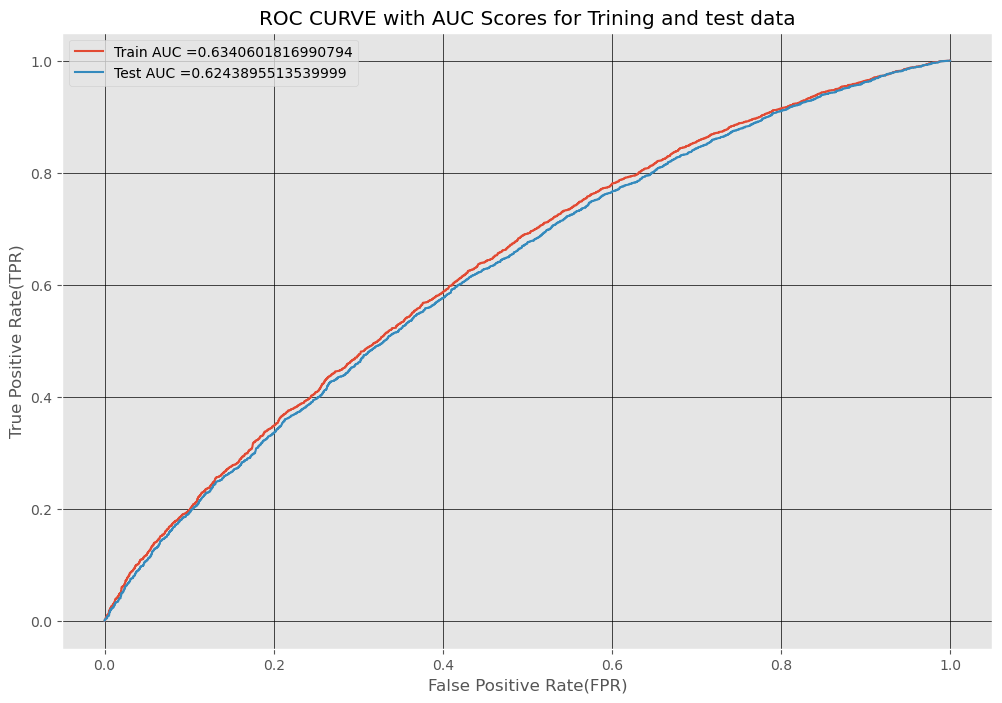

the maximum value of tpr*(1-fpr) 0.35602641207900615 for threshold 0.484
[[ 94304  71017]
 [ 62138 103183]]


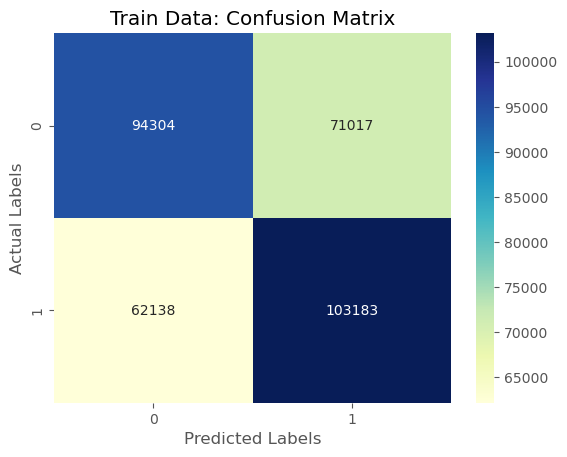

the maximum value of tpr*(1-fpr) 0.3490040479741657 for threshold 0.489
[[32129 23022]
 [22111 33040]]


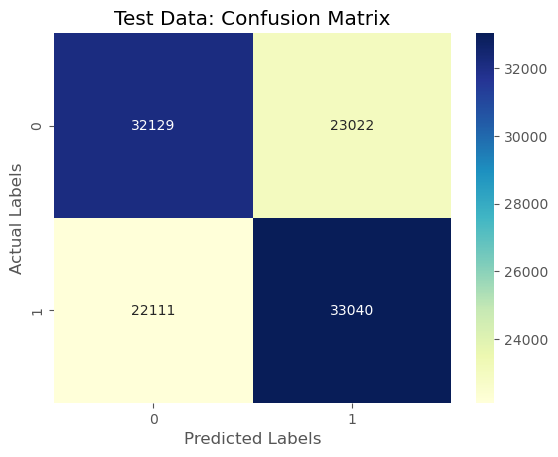

--------------classfication report for test data --------------------
              precision    recall  f1-score   support

           0       0.59      0.58      0.59     55151
           1       0.59      0.60      0.59     55151

    accuracy                           0.59    110302
   macro avg       0.59      0.59      0.59    110302
weighted avg       0.59      0.59      0.59    110302



In [ ]:
plot_evaluations_graphs(logistic_reg_model, X_train_resample, X_test_resample, y_train_resample, y_test_resample)

In [ ]:
print('best parameter grid :', logistic_reg_model.best_params_)
print('best score :',logistic_reg_model.best_score_)

best parameter grid : {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
best score : 0.6340060450493521


**Observations**

- We got roc_auc score about 0.62 on test data which is better than our base model.
- Recall and precision for class 1 is not that great.

## Decision Tree with HyperParameter Tunning

In [ ]:
## imports
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
from sklearn.tree import DecisionTreeClassifier
criterion = ['gini','entropy','log_loss']
max_depth = [2, 4, 6, 8]
min_samples_split = [50, 75, 100, 125]
max_features = ['auto','sqrt','log2']
param_grid = dict(criterion=criterion, max_depth=max_depth, max_features=max_features, min_samples_split=min_samples_split)
dt_model = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'), param_grid, cv=5, scoring='roc_auc',return_train_score=True, n_jobs=-1)

dt_model.fit(X_train_resample, y_train_resample)

/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 4, 6, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [50, 75, 100, 125]},
             return_train_score=True, scoring='roc_auc')

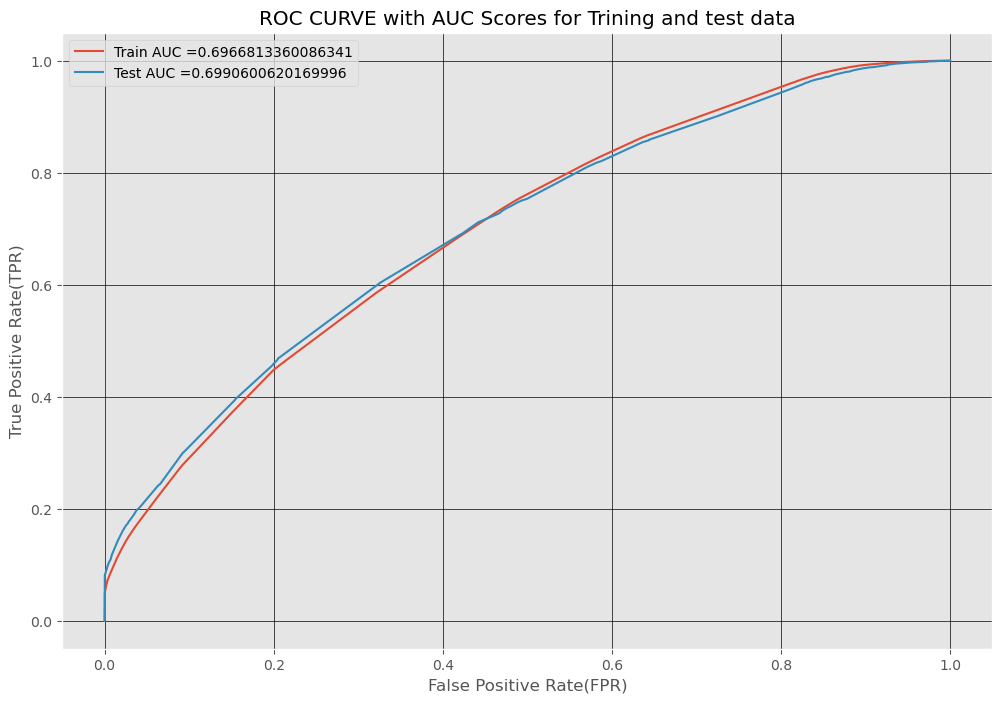

the maximum value of tpr*(1-fpr) 0.39838731794975035 for threshold 0.505
[[ 96450  68871]
 [ 52430 112891]]


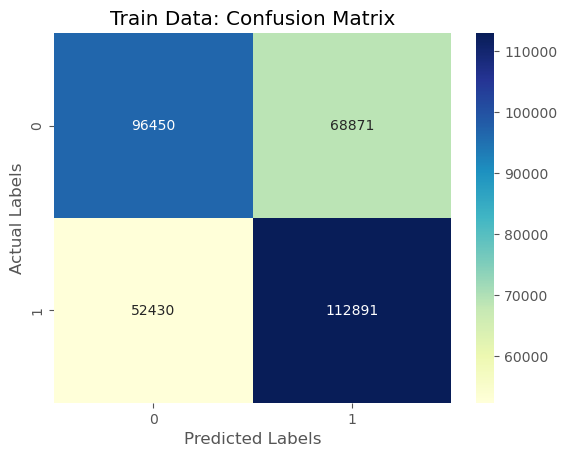

the maximum value of tpr*(1-fpr) 0.40688030935000424 for threshold 0.515
[[37159 17992]
 [21846 33305]]


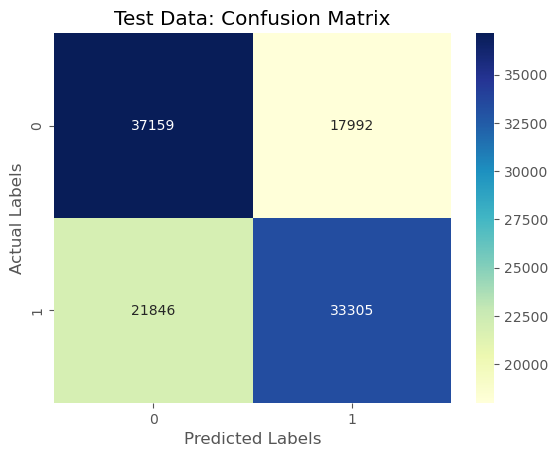

--------------classfication report for test data --------------------
              precision    recall  f1-score   support

           0       0.63      0.67      0.65     55151
           1       0.65      0.60      0.63     55151

    accuracy                           0.64    110302
   macro avg       0.64      0.64      0.64    110302
weighted avg       0.64      0.64      0.64    110302



In [ ]:
plot_evaluations_graphs(dt_model, X_train_resample, X_test_resample, y_train_resample, y_test_resample)

In [ ]:
print('best parameter grid :', dt_model.best_params_)
print('best score :',dt_model.best_score_)

best parameter grid : {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'min_samples_split': 100}
best score : 0.6898881786928255


**Observations**

- Here we see the slight improvement in the recall and precision with roc_auc score of 0.69 on test data.

## Random Forest with HyperParameter Tuning

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
from sklearn.ensemble import RandomForestClassifier
n_estimators = [21, 41, 61, 81]
max_features = ['sqrt', 'log2']
criterion = ['gini','entropy','log_loss']
max_depth = [2, 4, 6, 8]
min_samples_split = [50, 75, 100, 125]

param_grid = dict(n_estimators= n_estimators, max_features= max_features, max_depth=max_depth, criterion=criterion, min_samples_split=min_samples_split)

rf_model = GridSearchCV(RandomForestClassifier(class_weight='balanced', oob_score=True), param_grid, cv=5, scoring='roc_auc',return_train_score=True, n_jobs=-1)
rf_model.fit(X_train_resample, y_train_resample)

/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-package

/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-package

/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-package

/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-package

/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-package

/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-package

/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-package

/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-package

/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-package

/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-package

/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-package

/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-package

/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-package

/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/rtmagar/anaconda3/envs/rt/lib/python3.10/site-package

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              oob_score=True),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 4, 6, 8],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [50, 75, 100, 125],
                         'n_estimators': [21, 41, 61, 81]},
             return_train_score=True, scoring='roc_auc')

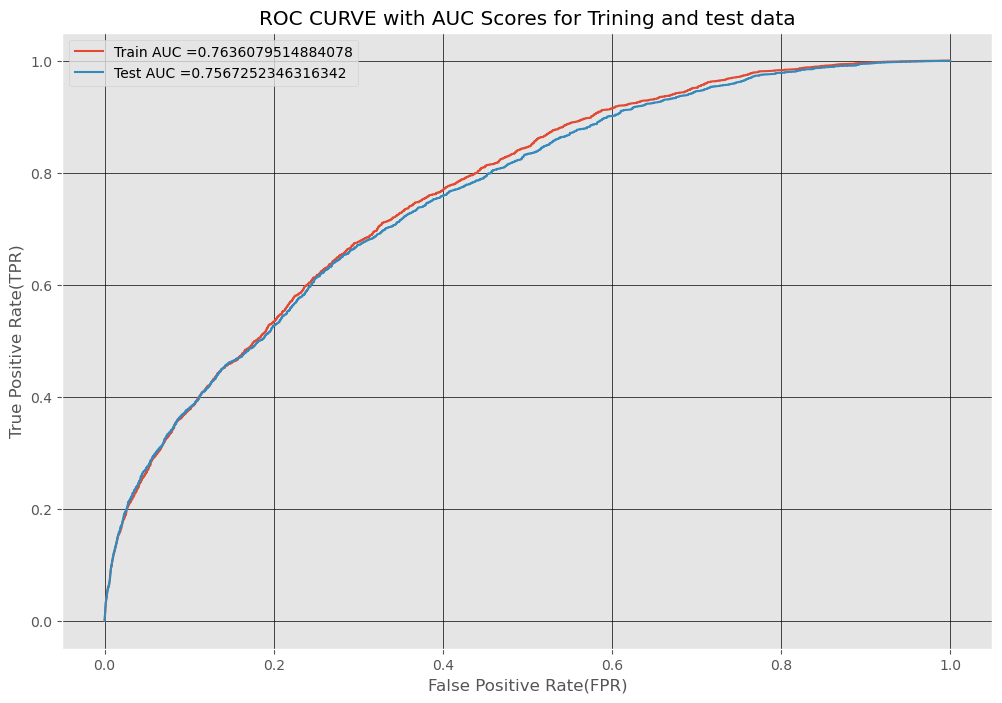

the maximum value of tpr*(1-fpr) 0.4771035715495552 for threshold 0.512
[[111106  54215]
 [ 47958 117363]]


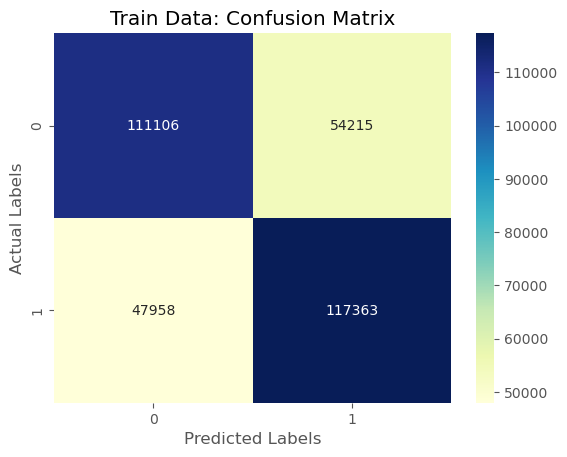

the maximum value of tpr*(1-fpr) 0.4701808007626099 for threshold 0.519
[[38679 16472]
 [18177 36974]]


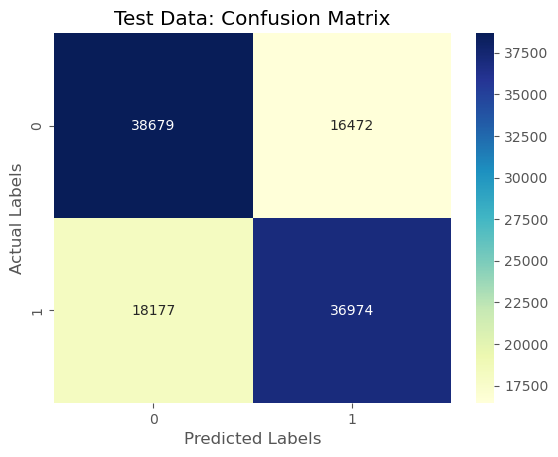

--------------classfication report for test data --------------------
              precision    recall  f1-score   support

           0       0.68      0.70      0.69     55151
           1       0.69      0.67      0.68     55151

    accuracy                           0.69    110302
   macro avg       0.69      0.69      0.69    110302
weighted avg       0.69      0.69      0.69    110302



In [ ]:
plot_evaluations_graphs(rf_model, X_train_resample, X_test_resample, y_train_resample, y_test_resample)

In [ ]:
print('best parameter grid :', rf_model.best_params_)
print('best score :',rf_model.best_score_)

best parameter grid : {'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 50, 'n_estimators': 81}
best score : 0.7641994933907009


**Observations**

- We see better result for random forest classifier with roc_auc score of 0.75 on test data.
- More improvment on the precision and recall score.

## Xgboost with HyperParameter Tuning

In [ ]:
import xgboost
# https://xgboost.readthedocs.io/en/stable/parameter.html
from sklearn.model_selection import RandomizedSearchCV

classifier = xgboost.XGBClassifier()
learning_rate = [0.01, 0.05, 0.10, 0.15, 0.20]
max_depth = [3, 4, 5, 6, 8, 10]
min_child_weight = [1, 3, 5, 7]
gamma = [0.0, 0.1, 0.2, 0.3, 0.4]
colsample_bytree = [0.0, 0.4, 0.5, 0.7]

param_grid = dict(learning_rate=learning_rate, max_depth=max_depth, min_child_weight=min_child_weight, gamma=gamma, colsample_bytree=colsample_bytree)
xgb_model=RandomizedSearchCV(classifier,param_distributions=param_grid,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
xgb_model.fit(X_train_resample, y_train_resample)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.0, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.15,
                                                          0.2],
                                        'max_depth': [3, 4, 5, 6, 8, 10],
                                        'min_child_weight': [1, 3, 5, 7]},
                   scoring='roc_auc', verbose=3)

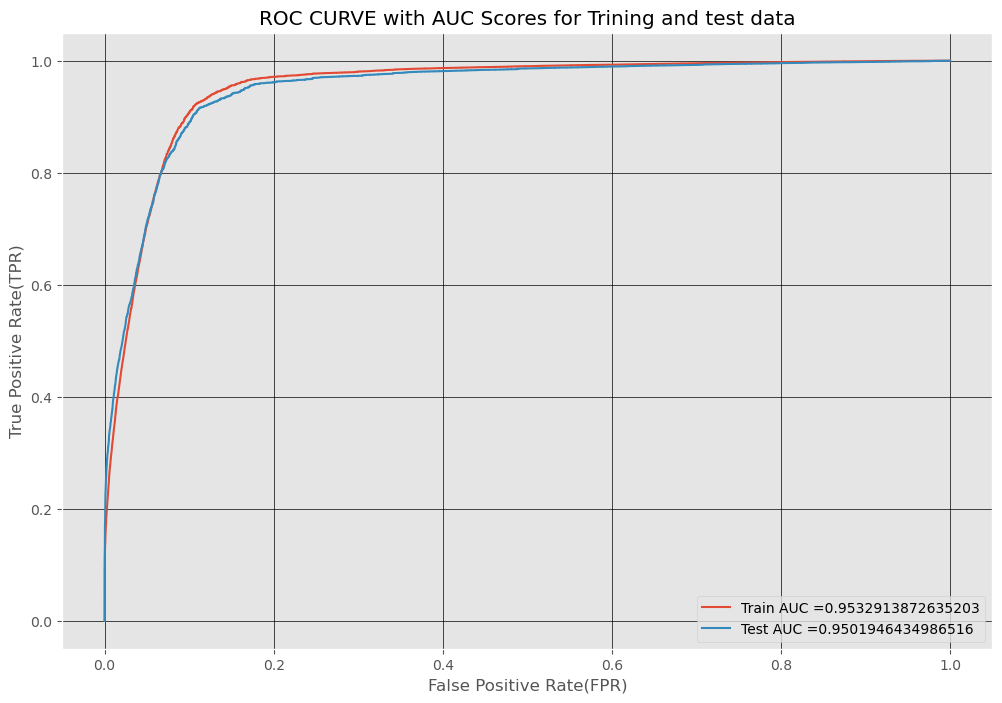

the maximum value of tpr*(1-fpr) 0.8232617148150336 for threshold 0.514
[[147287  18034]
 [ 12554 152767]]


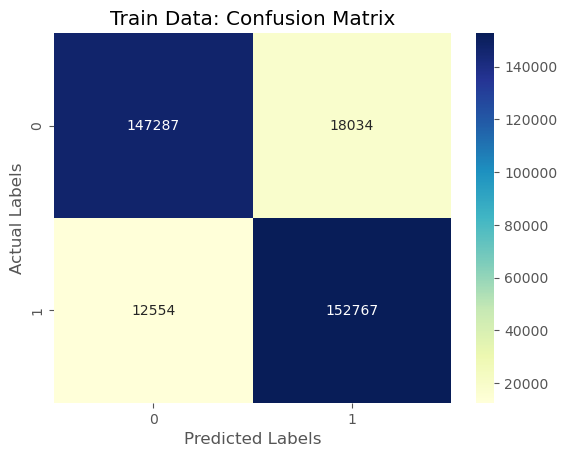

the maximum value of tpr*(1-fpr) 0.8131252112966677 for threshold 0.516
[[48969  6182]
 [ 4645 50506]]


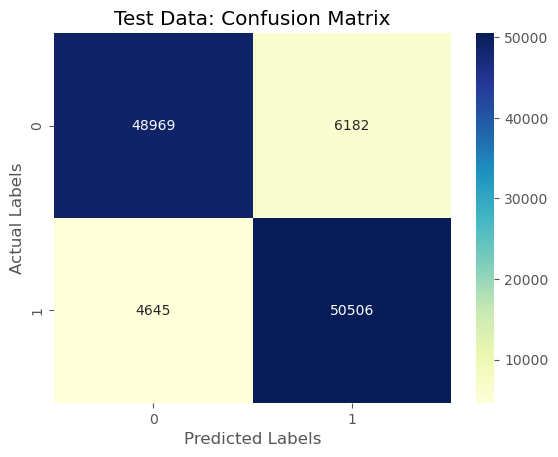

--------------classfication report for test data --------------------
              precision    recall  f1-score   support

           0       0.91      0.89      0.90     55151
           1       0.89      0.92      0.90     55151

    accuracy                           0.90    110302
   macro avg       0.90      0.90      0.90    110302
weighted avg       0.90      0.90      0.90    110302



In [ ]:
plot_evaluations_graphs(xgb_model, X_train_resample, X_test_resample, y_train_resample, y_test_resample)

In [ ]:
print('best parameter grid :', xgb_model.best_params_)
print('best score :',xgb_model.best_score_)

best parameter grid : {'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.5}
best score : 0.765316509009087


**Observations**

- The Xgboost outperformed compare to other three models with roc_auc score around 0.95 on test data
- We have best score so far with Precision and recall for both classes.

# Summary

In [ ]:
from prettytable import PrettyTable
table = PrettyTable()

table.field_names = ['No.', 'ML Model', 'Optimal Hyper Parameters', 'Train-AUC', 'Test-AUC']
table.add_row([1, 'Logistic Regression', '{best_params_lr}', 0.63, 0.62])
table.add_row([2, 'Decision Trees', '{best_params_dt}', 0.69, 0.69])
table.add_row([3, 'Random Forest', '{best_params_rf}', 0.76, 0.75])
table.add_row([4, 'Xgboost', '{best_params_xgb}', 0.95, 0.95])

print(table)


+-----+---------------------+--------------------------+-----------+----------+
| No. |       ML Model      | Optimal Hyper Parameters | Train-AUC | Test-AUC |
+-----+---------------------+--------------------------+-----------+----------+
|  1  | Logistic Regression |     {best_params_lr}     |    0.63   |   0.62   |
|  2  |    Decision Trees   |     {best_params_dt}     |    0.69   |   0.69   |
|  3  |    Random Forest    |     {best_params_rf}     |    0.76   |   0.75   |
|  4  |       Xgboost       |    {best_params_xgb}     |    0.95   |   0.95   |
+-----+---------------------+--------------------------+-----------+----------+
